In [99]:
import math
import re
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rtree
import tqdm
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from shapely import Point
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Scikit-learn modules for models and evaluation metrics
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR


In [26]:
# Read in both CSV files
file1_path = "data/Parcel_Data_2021_Table_-2691831558175163259.csv"

# Read the CSV files
df1 = pd.read_csv(file1_path)

# Display basic info about the dataframes
print(f"Dataset 1 shape: {df1.shape}")


Dataset 1 shape: (2424770, 51)


In [27]:
df1[df1["Property Location"].str.startswith("1017 HYPERION AVE", na=False)]


,Zip Code,City Tax Rate Area,AIN,Roll Year,Tax Rate Area Code,Assessor ID,Property Location,Property Use Type,Property Use Code,Use Code 1st Digit,...,Address House Number Fraction,Direction,Street,Unit Number,City,Zip Code.1,Row ID,Location Latitude,Location Longitude,OBJECTID
1252963,90029-3109,LOS ANGELES,5427007013,2024,13,5427-007-013,1017 HYPERION AVE LOS ANGELES CA 90029,R-I,0200,Residential,...,,,HYPERION AVE,,LOS ANGELES CA,90029.0,20245427007013,34.090412,-118.280831,56340440


In [28]:
df1["City Tax Rate Area"].value_counts()

City Tax Rate Area
LOS ANGELES       805738
unincorporated    326824
LONG BEACH        106381
SANTA CLARITA      71910
LANCASTER          50077
                   ...  
ROSEMEAD             269
MAYWOOD              213
PARAMOUNT             94
INDUSTRY              36
EL SEGUNDO             4
Name: count, Length: 123, dtype: int64

In [29]:
merged_df = df1

In [30]:
merged_df = merged_df[merged_df["City Tax Rate Area"] == "LOS ANGELES"]
merged_df

,Zip Code,City Tax Rate Area,AIN,Roll Year,Tax Rate Area Code,Assessor ID,Property Location,Property Use Type,Property Use Code,Use Code 1st Digit,...,Address House Number Fraction,Direction,Street,Unit Number,City,Zip Code.1,Row ID,Location Latitude,Location Longitude,OBJECTID
0,91304-3327,LOS ANGELES,2004001003,2024,16,2004-001-003,8321 FAUST AVE LOS ANGELES CA 91304,SFR,0101,Residential,...,,,FAUST AVE,,LOS ANGELES CA,91304.0,20242004001003,34.220225,-118.620681,55087477
1,91304-3327,LOS ANGELES,2004001004,2024,16,2004-001-004,8313 FAUST AVE LOS ANGELES CA 91304,SFR,0101,Residential,...,,,FAUST AVE,,LOS ANGELES CA,91304.0,20242004001004,34.220044,-118.620681,55087478
2,91304-3327,LOS ANGELES,2004001005,2024,16,2004-001-005,8309 FAUST AVE LOS ANGELES CA 91304,SFR,0100,Residential,...,,,FAUST AVE,,LOS ANGELES CA,91304.0,20242004001005,34.219862,-118.620688,55087479
3,91304-3332,LOS ANGELES,2004001008,2024,16,2004-001-008,8325 MAYNARD AVE LOS ANGELES CA 91304,SFR,0101,Residential,...,,,MAYNARD AVE,,LOS ANGELES CA,91304.0,20242004001008,34.220339,-118.622718,55087480
4,91304-3332,LOS ANGELES,2004001009,2024,16,2004-001-009,8311 MAYNARD AVE LOS ANGELES CA 91304,SFR,0101,Residential,...,,,MAYNARD AVE,,LOS ANGELES CA,91304.0,20242004001009,34.220327,-118.623062,55087481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016313,90732-4530,LOS ANGELES,7563037052,2024,20,7563-037-052,2193 WARMOUTH ST LOS ANGELES CA 90732,SFR,0100,Residential,...,,,WARMOUTH ST,,LOS ANGELES CA,90732.0,20247563037052,33.719514,-118.325376,57103790
2016314,90732-4519,LOS ANGELES,7563037053,2024,20,7563-037-053,3810 S ANCHOVY AVE LOS ANGELES CA 90732,SFR,0100,Residential,...,,S,ANCHOVY AVE,,LOS ANGELES CA,90732.0,20247563037053,33.719952,-118.325128,57103791
2016315,90732-4519,LOS ANGELES,7563037054,2024,20,7563-037-054,3806 S ANCHOVY AVE LOS ANGELES CA 90732,SFR,0100,Residential,...,,S,ANCHOVY AVE,,LOS ANGELES CA,90732.0,20247563037054,33.720119,-118.325081,57103792
2016316,90732-4556,LOS ANGELES,7563037055,2024,20,7563-037-055,2197 W PASEO DEL MAR LOS ANGELES CA 90732,SFR,0100,Residential,...,,W,PASEO DEL MAR,,LOS ANGELES CA,90732.0,20247563037055,33.720279,-118.325034,57103793


In [31]:
# Option 1: Set the display option to show all columns
pd.set_option("display.max_columns", None)

print(list(merged_df.columns))

['Zip Code', 'City Tax Rate Area', 'AIN', 'Roll Year', 'Tax Rate Area Code', 'Assessor ID', 'Property Location', 'Property Use Type', 'Property Use Code', 'Use Code 1st Digit', 'Use Code 2nd Digit', 'Use Code 3rd Digit', 'Use Code 4th Digit', 'Number of Buildings', 'Year Built', 'Effective Year', 'Square Footage', 'Number of Bedrooms', 'Number of Bathrooms', 'Number of Units', 'Recording Date', 'Land Value', 'Land Base Year', 'Improvement Value', 'Improvement Base Year', 'Total Value, Land + Improvement', 'Home Owners Exemption', 'Real Estate Exemption', 'Fixture Value', 'Fixture Exemption', 'Personal Property Value', 'Personal Property Exemption', 'Property taxable?', 'Total Value', 'Total Exemption', 'Taxable Value', 'Classification', 'Region Number', 'Cluster Code', 'Parcel Legal Description', 'Address House Number', 'Address House Number Fraction', 'Direction', 'Street', 'Unit Number', 'City', 'Zip Code.1', 'Row ID', 'Location Latitude', 'Location Longitude', 'OBJECTID']


In [32]:
selected = merged_df[
    [
        "Zip Code",
        "City Tax Rate Area",
        "AIN",
        "Roll Year",
        "Tax Rate Area Code",
        "Property Location",
        "Property Use Type",
        "Property Use Code",
        "Number of Buildings",
        "Year Built",
        "Effective Year",
        "Square Footage",
        "Number of Bedrooms",
        "Number of Bathrooms",
        "Number of Units",
        "Land Value",
        "Land Base Year",
        "Improvement Value",
        "Improvement Base Year",
        "Total Value, Land + Improvement",
        "Home Owners Exemption",
        "Real Estate Exemption",
        "Fixture Value",
        "Fixture Exemption",
        "Personal Property Value",
        "Personal Property Exemption",
        "Property taxable?",
        "Total Value",
        "Total Exemption",
        "Taxable Value",
        "Classification",
        "Region Number",
        "Location Latitude",
        "Location Longitude",
    ]
]

In [33]:
# selected["Total_Taxes_Paid_Calc"] = (
#     selected["F1ST_INSTALLMENT_TAX"] + selected["F2ND_INSTALLMENT_TAX"]
# )
# selected

In [34]:
zoning = gpd.read_file("data/ZONING_PLY_20250403.geojson")
zoning = zoning[["zone_cmplt", "geometry"]]
zoning

,zone_cmplt,geometry
0,(F)CM-1-CUGU,"MULTIPOLYGON (((-118.38793 34.22862, -118.3883..."
1,(F)CM-1-CUGU,"MULTIPOLYGON (((-118.38793 34.22959, -118.3883..."
2,(F)CM-1-CUGU,"MULTIPOLYGON (((-118.38793 34.23014, -118.3883..."
3,(F)CM-1-CUGU,"MULTIPOLYGON (((-118.38794 34.23041, -118.3883..."
4,(F)CM-1-CUGU,"MULTIPOLYGON (((-118.38794 34.2314, -118.38836..."
...,...,...
58658,C4-2D-SN,"MULTIPOLYGON (((-118.32464 34.10324, -118.3246..."
58659,C4-2D,"MULTIPOLYGON (((-118.33089 34.10051, -118.3302..."
58660,(T)(Q)C4-2D-SN,"MULTIPOLYGON (((-118.3306 34.1011, -118.33077 ..."
58661,[Q]C2-2L-CDO-CUGU,"MULTIPOLYGON (((-118.36707 34.2176, -118.36728..."


In [35]:
# Step 1: Convert the regular dataframe to a GeoDataFrame by creating Point geometries
# First, make a copy to avoid modifying the original
selected_gdf = selected.copy()

# Create a geometry column with Point objects from latitude and longitude
selected_gdf["geometry"] = selected_gdf.apply(
    lambda row: Point(row["Location Longitude"], row["Location Latitude"]), axis=1
)

# Convert to a GeoDataFrame
selected_gdf = gpd.GeoDataFrame(selected_gdf, geometry="geometry")

# Make sure both GeoDataFrames have the same CRS (Coordinate Reference System)
# If you know the CRS of your data, set it explicitly
# For example, if your coordinates are in WGS84:
selected_gdf.crs = "EPSG:4326"

# Ensure zoning has the same CRS, or reproject if needed
if zoning.crs != selected_gdf.crs:
    zoning = zoning.to_crs(selected_gdf.crs)

# Step 2: Perform spatial join - this will add zoning attributes to each point
joined_data = gpd.sjoin(selected_gdf, zoning, how="left", predicate="within")

# Step 3: If you want a regular dataframe with the original columns plus zoning info
# (You might want to drop the extra geometry column and index_right column)
result = pd.DataFrame(joined_data.drop(columns=["geometry", "index_right"]))

# Alternatively, if you want to add specific columns from zoning to your original dataframe:
# selected['zoning_type'] = joined_data['zoning_type']  # Replace with your actual column names

In [36]:
result["ZONE_PREFIX"] = result["zone_cmplt"].str.split("-").str[0]
result

,Zip Code,City Tax Rate Area,AIN,Roll Year,Tax Rate Area Code,Property Location,Property Use Type,Property Use Code,Number of Buildings,Year Built,Effective Year,Square Footage,Number of Bedrooms,Number of Bathrooms,Number of Units,Land Value,Land Base Year,Improvement Value,Improvement Base Year,"Total Value, Land + Improvement",Home Owners Exemption,Real Estate Exemption,Fixture Value,Fixture Exemption,Personal Property Value,Personal Property Exemption,Property taxable?,Total Value,Total Exemption,Taxable Value,Classification,Region Number,Location Latitude,Location Longitude,zone_cmplt,ZONE_PREFIX
0,91304-3327,LOS ANGELES,2004001003,2024,16,8321 FAUST AVE LOS ANGELES CA 91304,SFR,0101,1,1973,1973,2090,4,3,1,711689,2006,301176,2006,1012865,0,0,0,0,0,0,Y,1012865,0,1012865,,2,34.220225,-118.620681,RE9-1,RE9
1,91304-3327,LOS ANGELES,2004001004,2024,16,8313 FAUST AVE LOS ANGELES CA 91304,SFR,0101,1,1973,1973,2479,5,3,1,370538,2010,255879,2010,626417,0,0,0,0,0,0,Y,626417,0,626417,,2,34.220044,-118.620681,RE9-1,RE9
2,91304-3327,LOS ANGELES,2004001005,2024,16,8309 FAUST AVE LOS ANGELES CA 91304,SFR,0100,1,1973,1973,2057,4,2,1,526360,2018,198577,2018,724937,0,0,0,0,0,0,Y,724937,0,724937,,2,34.219862,-118.620688,RE9-1,RE9
3,91304-3332,LOS ANGELES,2004001008,2024,16,8325 MAYNARD AVE LOS ANGELES CA 91304,SFR,0101,1,1978,1978,2423,4,3,1,128421,1980,221965,1980,350386,7000,0,0,0,0,0,Y,350386,7000,343386,,2,34.220339,-118.622718,RE11-1,RE11
4,91304-3332,LOS ANGELES,2004001009,2024,16,8311 MAYNARD AVE LOS ANGELES CA 91304,SFR,0101,1,1978,1978,2226,4,3,1,139933,1984,210012,1984,349945,7000,0,0,0,0,0,Y,349945,7000,342945,,2,34.220327,-118.623062,RE11-1,RE11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016313,90732-4530,LOS ANGELES,7563037052,2024,20,2193 WARMOUTH ST LOS ANGELES CA 90732,SFR,0100,1,1959,1959,1933,3,3,1,485785,1995,263473,1995,749258,7000,0,0,0,0,0,Y,749258,7000,742258,,14,33.719514,-118.325376,R1-1XL,R1
2016314,90732-4519,LOS ANGELES,7563037053,2024,20,3810 S ANCHOVY AVE LOS ANGELES CA 90732,SFR,0100,1,1965,1965,2206,3,2,1,793428,2020,198356,2020,991784,0,0,0,0,0,0,Y,991784,0,991784,,14,33.719952,-118.325128,R1-1XL,R1
2016315,90732-4519,LOS ANGELES,7563037054,2024,20,3806 S ANCHOVY AVE LOS ANGELES CA 90732,SFR,0100,1,1959,1961,1862,3,2,1,703626,2008,175899,2008,879525,7000,0,0,0,0,0,Y,879525,7000,872525,,14,33.720119,-118.325081,R1-1XL,R1
2016316,90732-4556,LOS ANGELES,7563037055,2024,20,2197 W PASEO DEL MAR LOS ANGELES CA 90732,SFR,0100,1,1962,1962,2153,4,2,1,47779,1975,92991,1975,140770,7000,0,0,0,0,0,Y,140770,7000,133770,,14,33.720279,-118.325034,R1-1XL,R1


In [37]:
result["ZONE_PREFIX"].value_counts()

ZONE_PREFIX
R1          251717
R3           61757
RS           55071
R2           51911
RD1.5        36587
             ...  
[Q]R1P           1
(T)[Q]R3         1
(T)(Q)M3         1
[T]RE9           1
SL               1
Name: count, Length: 303, dtype: int64

In [38]:
parcels = gpd.read_file("data/Parcels.gdb", columns=["AIN", "geometry"])

In [39]:
parcels["AIN"] = pd.to_numeric(parcels["AIN"], errors="coerce").astype(
    "Int64"
)  # Keeps NaNs


In [40]:
merged_results = pd.merge(
    result,
    parcels,
    on="AIN",  # Join on the AIN column that exists in both dataframes
    how="left",  # Keep all rows from 'result' even if no matching AIN in parcels
)

# If you want to convert the merged result back to a GeoDataFrame
# (in case you need to do more spatial operations later)
# Note: This will use the geometry from the parcels dataframe
merged_gdf = gpd.GeoDataFrame(merged_results, geometry="geometry")

In [41]:
projected_gdf = merged_gdf.to_crs("EPSG:2229")

# Calculate area in square feet first (State Plane uses US Survey Feet)
projected_gdf["area_sq_feet"] = projected_gdf.geometry.area

# Convert to acres (1 acre = 43,560 square feet)
projected_gdf["acreage"] = projected_gdf["area_sq_feet"] / 43560

# Drop the intermediate area calculation if you don't need it
projected_gdf = projected_gdf.drop(columns=["area_sq_feet"])

# If you want to round the acreage to a specific number of decimal places
projected_gdf["acreage"] = projected_gdf["acreage"].round(3)

# Convert back to original CRS if needed for further spatial operations
final_gdf = projected_gdf.to_crs(merged_gdf.crs)

In [42]:
final_gdf[final_gdf["Property Location"].str.startswith("1017 HYPERION AVE", na=False)]


,Zip Code,City Tax Rate Area,AIN,Roll Year,Tax Rate Area Code,Property Location,Property Use Type,Property Use Code,Number of Buildings,Year Built,Effective Year,Square Footage,Number of Bedrooms,Number of Bathrooms,Number of Units,Land Value,Land Base Year,Improvement Value,Improvement Base Year,"Total Value, Land + Improvement",Home Owners Exemption,Real Estate Exemption,Fixture Value,Fixture Exemption,Personal Property Value,Personal Property Exemption,Property taxable?,Total Value,Total Exemption,Taxable Value,Classification,Region Number,Location Latitude,Location Longitude,zone_cmplt,ZONE_PREFIX,geometry,acreage
618932,90029-3109,LOS ANGELES,5427007013,2024,13,1017 HYPERION AVE LOS ANGELES CA 90029,R-I,0200,2,1946,1952,2184,6,2,2,1096500,2023,418200,2023,1514700,0,0,0,0,0,0,Y,1514700,0,1514700,,4,34.090412,-118.280831,R3-1VL,R3,"MULTIPOLYGON (((6476718.72 1855390.06, 6476695...",0.168


In [43]:
final_gdf["Property_Tax_Value"] = final_gdf["Taxable Value"] * 0.01

In [44]:
final_gdf = final_gdf.dropna(subset=["acreage"])

In [45]:
final_gdf[final_gdf["acreage"].isna()]


,Zip Code,City Tax Rate Area,AIN,Roll Year,Tax Rate Area Code,Property Location,Property Use Type,Property Use Code,Number of Buildings,Year Built,Effective Year,Square Footage,Number of Bedrooms,Number of Bathrooms,Number of Units,Land Value,Land Base Year,Improvement Value,Improvement Base Year,"Total Value, Land + Improvement",Home Owners Exemption,Real Estate Exemption,Fixture Value,Fixture Exemption,Personal Property Value,Personal Property Exemption,Property taxable?,Total Value,Total Exemption,Taxable Value,Classification,Region Number,Location Latitude,Location Longitude,zone_cmplt,ZONE_PREFIX,geometry,acreage,Property_Tax_Value


In [46]:
final_gdf["Property_Tax_Value"].sum() * 0.2478


np.float64(2001904733.5903978)

In [47]:
# Function to extract first letter of zoning code
def extract_first_letter(zone_code):
    if pd.isna(zone_code):
        return None

    # Remove any brackets or parentheses and their contents
    # This regex looks for patterns like [...], (...), etc.
    cleaned_code = re.sub(r"[\[\(].*?[\]\)]", "", zone_code)
    cleaned_prefix = cleaned_code

    # Remove any remaining special characters
    cleaned_code = re.sub(r"[^a-zA-Z0-9]", "", cleaned_code)
    cleaned_code = cleaned_code.replace("Q", "")

    # Take the first letter if there is one
    if cleaned_code and len(cleaned_code) > 0:
        return cleaned_code[0], cleaned_prefix
    else:
        return None, None


def extract_zone_district_clean(zone_code):
    if pd.isna(zone_code):
        return None

    # Remove anything inside () or [] and the brackets themselves
    cleaned = re.sub(r"[\(\[].*?[\)\]]", "", zone_code).strip()

    cleaned = cleaned.replace("Q", "")

    # Find the first occurrence of a dash and keep one character after it
    match = re.match(r"([A-Za-z0-9]+-\w?)", cleaned)
    if match:
        return match.group(1)

    return None


# Apply to final_gdf
final_gdf["zone_district_clean"] = final_gdf["zone_cmplt"].apply(
    extract_zone_district_clean
)


# Apply and split into two columns properly
zone_extracted = final_gdf["ZONE_PREFIX"].apply(extract_first_letter).apply(pd.Series)
zone_extracted.columns = ["zone_type", "zone_prefix_clean"]

# Add them to the original DataFrame
final_gdf[["zone_type", "zone_prefix_clean"]] = zone_extracted

# Remove all 'Q' characters from zone_prefix_clean and zone_district_clean
final_gdf["zone_prefix_clean"] = final_gdf["zone_prefix_clean"].str.replace(
    "Q", "", regex=False
)
final_gdf["zone_district_clean"] = final_gdf["zone_district_clean"].str.replace(
    "Q", "", regex=False
)


In [48]:
# Define logic for zone_consolidation
def consolidate_zone(row):
    if row["zone_prefix_clean"] in ["C2", "C4"]:
        return row["zone_district_clean"]
    return row["zone_prefix_clean"]


# Apply the function row-wise
final_gdf["zone_consolidation"] = final_gdf.apply(consolidate_zone, axis=1)
print(final_gdf["zone_consolidation"].value_counts())

zone_consolidation
R1        259971
R3         86790
RS         55475
R2         52510
RD1.5      48875
           ...  
R2P            8
LACFCD         5
C4-3           1
CCS            1
SL             1
Name: count, Length: 94, dtype: int64


In [49]:
print(final_gdf["ZONE_PREFIX"].unique())

['RE9' 'RE11' 'OS' '[Q]OS' '(Q)R1' '(Q)RE11' '(Q)RD3' '[T][Q]M1' 'A1' 'RS'
 'C2' '[Q]M1' 'R3' 'C4' 'P' '[Q]PF' '(T)(Q)C1.5' 'CR' nan '(T)(Q)R4'
 '(Q)R3' '(T)RS' 'R1' 'RA' '[Q]C1' '[Q]C1.5' '(Q)RD5' 'RE20' 'RE40' 'RE15'
 '(T)RE11' 'A2' 'QCR' '(T)(Q)CR' 'QC1' '(Q)RD2' 'QRD3' '[Q]CR' '[Q]C2'
 'C1' '(T)(Q)C2' 'R1P' 'C1.5' 'R2' '(Q)C1.5' '(WC)TOPANGA' '(T)(Q)RD2'
 'RD2' 'RD1.5' '(Q)RD1.5' '(Q)RD6' '(T)(Q)R1' '(Q)CR' '(T)(Q)RD3'
 '(T)(Q)RD5' '(Q)C1' '[Q]C4' 'QC2' '(Q)P' '(T)(Q)C1' 'PF' '(T)R1' '[Q]R3'
 '(T)R3' 'QRD5' '(Q)C2' 'R4' '(T)RE9' '(T)(Q)RD4' '(Q)RE9' '(T)(Q)R3'
 '(Q)C4' 'M2' 'MR1' '(Q)MR1' '[Q]CM' '[T][Q]C2' '(T)(Q)RZ3' '[Q]RD2'
 '[Q]P' '(Q)R3P' '(T)(Q)RD1.5' '(Q)M1' 'RD5' 'M1' 'RD3' '(T)(Q)M1' 'QR3'
 '(Q)RS' '[T]R3' 'QRD1.5' 'R3P' '(Q)R4' '(Q)RZ2.5' '(Q)R2' '[Q]R2' '[Q]R1'
 '(Q)RD4' '(T)[Q]C2' '[T]R1' '(T)[Q]R4' '(T)(Q)RAS4' '[Q]RD5' '(Q)RAS3'
 '(T)(Q)RAS3' '(T)[Q]RAS4' 'RMP' '[T]RD2' '[T][Q]RD1.5' 'QRD2' '(T)(Q)C4'
 '[Q]RD3' '(WC)RIVER' '(Q)RAS4' '[T][Q]MR1' '[Q]MR1' '(WC)UPTOWN'


In [50]:
print(final_gdf["zone_prefix_clean"].unique())

['RE9' 'RE11' 'OS' 'R1' 'RD3' 'M1' 'A1' 'RS' 'C2' 'R3' 'C4' 'P' 'PF'
 'C1.5' 'CR' nan 'R4' 'RA' 'C1' 'RD5' 'RE20' 'RE40' 'RE15' 'A2' 'RD2'
 'R1P' 'R2' 'TOPANGA' 'RD1.5' 'RD6' 'RD4' 'M2' 'MR1' 'CM' 'RZ3' 'R3P'
 'RZ2.5' 'RAS4' 'RAS3' 'RMP' 'RIVER' 'UPTOWN' 'DOWNTOWN' 'PARK'
 'NORTHVILLAGE' 'COLLEGE' 'COMMERCE' 'RZ5' 'PB' 'R2P' 'MR2' 'R5' 'M3' 'RU'
 'RE' 'RZ4' 'R1V2' 'LAX' 'MU' 'R5P' 'LACFCD' 'M' 'RW2' 'RW1' 'NMU' 'HJ'
 'HR' 'NI' 'R1R3' 'CCS' 'R1V3' 'R4P' 'R1V1' 'R1H1' 'USC' 'CEC' 'CW'
 'LASED' 'C5' 'GW' 'UI' 'UC' 'UV' 'ADP' 'PPSP' 'PVSP' 'SL']


In [51]:
final_gdf[final_gdf["zone_consolidation"] == None]

,Zip Code,City Tax Rate Area,AIN,Roll Year,Tax Rate Area Code,Property Location,Property Use Type,Property Use Code,Number of Buildings,Year Built,Effective Year,Square Footage,Number of Bedrooms,Number of Bathrooms,Number of Units,Land Value,Land Base Year,Improvement Value,Improvement Base Year,"Total Value, Land + Improvement",Home Owners Exemption,Real Estate Exemption,Fixture Value,Fixture Exemption,Personal Property Value,Personal Property Exemption,Property taxable?,Total Value,Total Exemption,Taxable Value,Classification,Region Number,Location Latitude,Location Longitude,zone_cmplt,ZONE_PREFIX,geometry,acreage,Property_Tax_Value,zone_district_clean,zone_type,zone_prefix_clean,zone_consolidation


In [52]:
print(final_gdf["zone_consolidation"].unique())

['RE9' 'RE11' 'OS' 'R1' 'RD3' 'M1' 'A1' 'RS' 'C2-1' 'R3' 'C4-1' 'P' 'PF'
 'C1.5' 'CR' nan 'R4' 'RA' 'C1' 'RD5' 'RE20' 'RE40' 'RE15' 'A2' 'RD2'
 'R1P' 'R2' 'TOPANGA' 'RD1.5' 'RD6' 'RD4' 'M2' 'MR1' 'CM' 'RZ3' 'R3P'
 'RZ2.5' 'C2-2' 'RAS4' 'RAS3' 'RMP' 'RIVER' 'UPTOWN' 'DOWNTOWN' 'PARK'
 'NORTHVILLAGE' 'COLLEGE' 'COMMERCE' 'C4-2' 'RZ5' 'PB' 'R2P' 'MR2' 'R5'
 'C2-4' 'M3' 'C2-E' 'RU' 'RE' 'RZ4' 'R1V2' 'LAX' 'MU' 'R5P' 'LACFCD' None
 'M' 'RW2' 'RW1' 'NMU' 'HJ' 'HR' 'NI' 'R1R3' 'CCS' 'R1V3' 'R4P' 'C4-3'
 'R1V1' 'R1H1' 'USC' 'C4-4' 'CEC' 'CW' 'LASED' 'C5' 'C2-3' 'GW' 'UI' 'UC'
 'UV' 'ADP' 'PPSP' 'C2-C' 'PVSP' 'SL']


In [53]:
zone_acreage_summary = (
    final_gdf.groupby("zone_consolidation")["acreage"]
    .sum()
    .sort_values(ascending=False)
    .to_dict()
)
print(zone_acreage_summary)


{'R3': 88158.593, 'RD2': 52381.267, 'R1': 42727.447, 'RD6': 41667.687, 'OS': 38958.049, 'RD1.5': 36763.123, 'R4': 26532.625, 'RD3': 24632.44, 'A1': 17422.157, 'RE15': 16920.496, 'RA': 15127.92, 'RD4': 13224.246, 'RD5': 11955.235, 'RE40': 11429.559, 'PF': 11269.799, 'RS': 10869.322, 'M3': 9025.179, 'M2': 8994.865, 'C2-1': 8922.697, 'C2-2': 8445.511, 'RE11': 7674.149, 'PARK': 7478.317, 'R2': 7204.043, 'R5': 6760.191, 'C4-2': 6074.094, 'C2-4': 4696.931, 'A2': 3521.638, 'LAX': 3318.554, 'RE20': 2924.194, 'M1': 2906.777, 'R1V2': 2857.489, 'CM': 2599.049, 'LASED': 2179.543, 'MR2': 1961.189, 'RE9': 1744.099, 'C4-1': 1686.964, 'MR1': 1597.391, 'DOWNTOWN': 1387.719, 'ADP': 1184.105, 'RE': 1139.277, 'CW': 970.2139999999999, 'C1': 898.409, 'P': 782.413, 'C5': 764.068, 'CR': 759.319, 'R1R3': 580.321, 'C4-4': 526.492, 'C1.5': 377.216, 'C2-3': 338.696, 'RMP': 331.459, 'UV': 320.46500000000003, 'R1V3': 306.129, 'UI': 304.288, 'COLLEGE': 251.28799999999998, 'R1V1': 236.341, 'PB': 229.352, 'RAS4': 222.

In [54]:
# final_gdf.to_csv("LA_City_Property_Parcel_Acreage_Zoning_Tax_Data.csv")

In [55]:
# Load the spreadsheet (update path as needed)
zoning_map_df = pd.read_csv("data/Parcel tax by zoning - assigned zoning.csv")

# Create the dictionary mapping
abridged_to_bucket = dict(
    zip(zoning_map_df["Abridged Zoning Class"], zoning_map_df["Assigned Zoning Bucket"])
)

print(abridged_to_bucket)

{'R5': 'R5', 'R5P': 'R5', 'LASED': 'R5', 'C2-4': 'R5', 'C4-4': 'R5', 'C5': 'R4', 'R4': 'R4', 'R4P': 'R4', 'UI': 'R4', 'UV': 'R4', 'COLLEGE': 'R4', 'COMMERCE': 'R4', 'DOWNTOWN': 'R4', 'UPTOWN': 'R4', 'NORTHVILLAGE': 'R4', 'PARK': 'R4', 'RIVER': 'R4', 'TOPANGA': 'R4', 'CW': 'R4', 'C2-2': 'R4', 'C4-2': 'R4', 'C2-3': 'R3', 'C4-3': 'R4', 'CR': 'R3', 'R3': 'R3', 'R3P': 'R3', 'CM': 'R3', 'C1': 'R3', 'C1.5': 'R3', 'C4-1': 'R3', 'R2': 'R2', 'R2P': 'R2', 'RD1.5': 'R3', 'RD2': 'R3', 'RD3': 'R3', 'RD4': 'R3', 'RD5': 'R3', 'RD6': 'R3', 'RMP': 'R2', 'RW2': 'R2', 'PVSP': 'R2', 'C2-1': 'R4', 'R1': 'R1', 'R1H1': 'R1', 'R1P': 'R1', 'R1R3': 'R1', 'R1V1': 'R1', 'R1V2': 'R1', 'R1V3': 'R1', 'RA': 'R1', 'RAS3': 'R3', 'RAS4': 'R4', 'RE': 'R1', 'RE11': 'R1', 'RE15': 'R1', 'RE20': 'R1', 'RE40': 'R1', 'RE9': 'R1', 'RU': 'R1', 'RW1': 'R1', 'RZ2.5': 'R1', 'RZ3': 'R1', 'RZ4': 'R1', 'RZ5': 'R1', 'RS': 'R1', 'P': 'Parking', 'PB': 'Parking', 'ADP': 'Ignore', 'GW': 'Ignore', 'HR': 'Ignore', 'HJ': 'Ignore', 'NI': 'Ignor

In [56]:
abridged_to_bucket["RD2"]

'R3'

In [57]:
# Apply the dictionary to create a new column
final_gdf["assigned_zoning_bucket"] = final_gdf["zone_consolidation"].map(
    abridged_to_bucket
)
final_gdf

,Zip Code,City Tax Rate Area,AIN,Roll Year,Tax Rate Area Code,Property Location,Property Use Type,Property Use Code,Number of Buildings,Year Built,Effective Year,Square Footage,Number of Bedrooms,Number of Bathrooms,Number of Units,Land Value,Land Base Year,Improvement Value,Improvement Base Year,"Total Value, Land + Improvement",Home Owners Exemption,Real Estate Exemption,Fixture Value,Fixture Exemption,Personal Property Value,Personal Property Exemption,Property taxable?,Total Value,Total Exemption,Taxable Value,Classification,Region Number,Location Latitude,Location Longitude,zone_cmplt,ZONE_PREFIX,geometry,acreage,Property_Tax_Value,zone_district_clean,zone_type,zone_prefix_clean,zone_consolidation,assigned_zoning_bucket
0,91304-3327,LOS ANGELES,2004001003,2024,16,8321 FAUST AVE LOS ANGELES CA 91304,SFR,0101,1,1973,1973,2090,4,3,1,711689,2006,301176,2006,1012865,0,0,0,0,0,0,Y,1012865,0,1012865,,2,34.220225,-118.620681,RE9-1,RE9,"MULTIPOLYGON (((6374111.56 1903072, 6373962.55...",0.222,10128.65,RE9-1,R,RE9,RE9,R1
1,91304-3327,LOS ANGELES,2004001004,2024,16,8313 FAUST AVE LOS ANGELES CA 91304,SFR,0101,1,1973,1973,2479,5,3,1,370538,2010,255879,2010,626417,0,0,0,0,0,0,Y,626417,0,626417,,2,34.220044,-118.620681,RE9-1,RE9,"MULTIPOLYGON (((6374111.3 1903005.49, 6373962....",0.227,6264.17,RE9-1,R,RE9,RE9,R1
2,91304-3327,LOS ANGELES,2004001005,2024,16,8309 FAUST AVE LOS ANGELES CA 91304,SFR,0100,1,1973,1973,2057,4,2,1,526360,2018,198577,2018,724937,0,0,0,0,0,0,Y,724937,0,724937,,2,34.219862,-118.620688,RE9-1,RE9,"MULTIPOLYGON (((6374111.18 1902981.92, 6374110...",0.221,7249.37,RE9-1,R,RE9,RE9,R1
3,91304-3332,LOS ANGELES,2004001008,2024,16,8325 MAYNARD AVE LOS ANGELES CA 91304,SFR,0101,1,1978,1978,2423,4,3,1,128421,1980,221965,1980,350386,7000,0,0,0,0,0,Y,350386,7000,343386,,2,34.220339,-118.622718,RE11-1,RE11,"MULTIPOLYGON (((6373473.92 1903186.75, 6373474...",0.271,3433.86,RE11-1,R,RE11,RE11,R1
4,91304-3332,LOS ANGELES,2004001009,2024,16,8311 MAYNARD AVE LOS ANGELES CA 91304,SFR,0101,1,1978,1978,2226,4,3,1,139933,1984,210012,1984,349945,7000,0,0,0,0,0,Y,349945,7000,342945,,2,34.220327,-118.623062,RE11-1,RE11,"MULTIPOLYGON (((6373402.6 1903070.94, 6373399....",0.342,3429.45,RE11-1,R,RE11,RE11,R1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805739,90732-4530,LOS ANGELES,7563037052,2024,20,2193 WARMOUTH ST LOS ANGELES CA 90732,SFR,0100,1,1959,1959,1933,3,3,1,485785,1995,263473,1995,749258,7000,0,0,0,0,0,Y,749258,7000,742258,,14,33.719514,-118.325376,R1-1XL,R1,"MULTIPOLYGON (((6462789.35 1720524.86, 6462724...",0.261,7422.58,R1-1,R,R1,R1,R1
805740,90732-4519,LOS ANGELES,7563037053,2024,20,3810 S ANCHOVY AVE LOS ANGELES CA 90732,SFR,0100,1,1965,1965,2206,3,2,1,793428,2020,198356,2020,991784,0,0,0,0,0,0,Y,991784,0,991784,,14,33.719952,-118.325128,R1-1XL,R1,"MULTIPOLYGON (((6462857.6 1720642.09, 6462845....",0.170,9917.84,R1-1,R,R1,R1,R1
805741,90732-4519,LOS ANGELES,7563037054,2024,20,3806 S ANCHOVY AVE LOS ANGELES CA 90732,SFR,0100,1,1959,1961,1862,3,2,1,703626,2008,175899,2008,879525,7000,0,0,0,0,0,Y,879525,7000,872525,,14,33.720119,-118.325081,R1-1XL,R1,"MULTIPOLYGON (((6462871.53 1720700.47, 6462859...",0.158,8725.25,R1-1,R,R1,R1,R1
805742,90732-4556,LOS ANGELES,7563037055,2024,20,2197 W PASEO DEL MAR LOS ANGELES CA 90732,SFR,0100,1,1962,1962,2153,4,2,1,47779,1975,92991,1975,140770,7000,0,0,0,0,0,Y,140770,7000,133770,,14,33.720279,-118.325034,R1-1XL,R1,"MULTIPOLYGON (((6462793.22 1720781.15, 6462885...",0.157,1337.70,R1-1,R,R1,R1,R1


In [58]:
final_gdf["assigned_zoning_bucket"].value_counts()

assigned_zoning_bucket
R1         435573
R3         205758
R4          61560
R2          53030
Ignore      32386
R5          10703
Parking      1085
Name: count, dtype: int64

In [59]:
missing_count = final_gdf["assigned_zoning_bucket"].isna().sum()
print(f"Rows with missing zoning bucket: {missing_count}")


Rows with missing zoning bucket: 4435


In [60]:
final_buckets = final_gdf[final_gdf["assigned_zoning_bucket"] != "Ignore"]
final_buckets = final_buckets.dropna(subset=["assigned_zoning_bucket"])
final_buckets

,Zip Code,City Tax Rate Area,AIN,Roll Year,Tax Rate Area Code,Property Location,Property Use Type,Property Use Code,Number of Buildings,Year Built,Effective Year,Square Footage,Number of Bedrooms,Number of Bathrooms,Number of Units,Land Value,Land Base Year,Improvement Value,Improvement Base Year,"Total Value, Land + Improvement",Home Owners Exemption,Real Estate Exemption,Fixture Value,Fixture Exemption,Personal Property Value,Personal Property Exemption,Property taxable?,Total Value,Total Exemption,Taxable Value,Classification,Region Number,Location Latitude,Location Longitude,zone_cmplt,ZONE_PREFIX,geometry,acreage,Property_Tax_Value,zone_district_clean,zone_type,zone_prefix_clean,zone_consolidation,assigned_zoning_bucket
0,91304-3327,LOS ANGELES,2004001003,2024,16,8321 FAUST AVE LOS ANGELES CA 91304,SFR,0101,1,1973,1973,2090,4,3,1,711689,2006,301176,2006,1012865,0,0,0,0,0,0,Y,1012865,0,1012865,,2,34.220225,-118.620681,RE9-1,RE9,"MULTIPOLYGON (((6374111.56 1903072, 6373962.55...",0.222,10128.65,RE9-1,R,RE9,RE9,R1
1,91304-3327,LOS ANGELES,2004001004,2024,16,8313 FAUST AVE LOS ANGELES CA 91304,SFR,0101,1,1973,1973,2479,5,3,1,370538,2010,255879,2010,626417,0,0,0,0,0,0,Y,626417,0,626417,,2,34.220044,-118.620681,RE9-1,RE9,"MULTIPOLYGON (((6374111.3 1903005.49, 6373962....",0.227,6264.17,RE9-1,R,RE9,RE9,R1
2,91304-3327,LOS ANGELES,2004001005,2024,16,8309 FAUST AVE LOS ANGELES CA 91304,SFR,0100,1,1973,1973,2057,4,2,1,526360,2018,198577,2018,724937,0,0,0,0,0,0,Y,724937,0,724937,,2,34.219862,-118.620688,RE9-1,RE9,"MULTIPOLYGON (((6374111.18 1902981.92, 6374110...",0.221,7249.37,RE9-1,R,RE9,RE9,R1
3,91304-3332,LOS ANGELES,2004001008,2024,16,8325 MAYNARD AVE LOS ANGELES CA 91304,SFR,0101,1,1978,1978,2423,4,3,1,128421,1980,221965,1980,350386,7000,0,0,0,0,0,Y,350386,7000,343386,,2,34.220339,-118.622718,RE11-1,RE11,"MULTIPOLYGON (((6373473.92 1903186.75, 6373474...",0.271,3433.86,RE11-1,R,RE11,RE11,R1
4,91304-3332,LOS ANGELES,2004001009,2024,16,8311 MAYNARD AVE LOS ANGELES CA 91304,SFR,0101,1,1978,1978,2226,4,3,1,139933,1984,210012,1984,349945,7000,0,0,0,0,0,Y,349945,7000,342945,,2,34.220327,-118.623062,RE11-1,RE11,"MULTIPOLYGON (((6373402.6 1903070.94, 6373399....",0.342,3429.45,RE11-1,R,RE11,RE11,R1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805739,90732-4530,LOS ANGELES,7563037052,2024,20,2193 WARMOUTH ST LOS ANGELES CA 90732,SFR,0100,1,1959,1959,1933,3,3,1,485785,1995,263473,1995,749258,7000,0,0,0,0,0,Y,749258,7000,742258,,14,33.719514,-118.325376,R1-1XL,R1,"MULTIPOLYGON (((6462789.35 1720524.86, 6462724...",0.261,7422.58,R1-1,R,R1,R1,R1
805740,90732-4519,LOS ANGELES,7563037053,2024,20,3810 S ANCHOVY AVE LOS ANGELES CA 90732,SFR,0100,1,1965,1965,2206,3,2,1,793428,2020,198356,2020,991784,0,0,0,0,0,0,Y,991784,0,991784,,14,33.719952,-118.325128,R1-1XL,R1,"MULTIPOLYGON (((6462857.6 1720642.09, 6462845....",0.170,9917.84,R1-1,R,R1,R1,R1
805741,90732-4519,LOS ANGELES,7563037054,2024,20,3806 S ANCHOVY AVE LOS ANGELES CA 90732,SFR,0100,1,1959,1961,1862,3,2,1,703626,2008,175899,2008,879525,7000,0,0,0,0,0,Y,879525,7000,872525,,14,33.720119,-118.325081,R1-1XL,R1,"MULTIPOLYGON (((6462871.53 1720700.47, 6462859...",0.158,8725.25,R1-1,R,R1,R1,R1
805742,90732-4556,LOS ANGELES,7563037055,2024,20,2197 W PASEO DEL MAR LOS ANGELES CA 90732,SFR,0100,1,1962,1962,2153,4,2,1,47779,1975,92991,1975,140770,7000,0,0,0,0,0,Y,140770,7000,133770,,14,33.720279,-118.325034,R1-1XL,R1,"MULTIPOLYGON (((6462793.22 1720781.15, 6462885...",0.157,1337.70,R1-1,R,R1,R1,R1


In [61]:
final_geom = final_buckets[
    [
        "geometry",
        "AIN",
        "Property Location",
        "zone_type",
        "acreage",
        "Number of Units",
        "Property_Tax_Value",
        "zone_cmplt",
        "zone_consolidation",
        "assigned_zoning_bucket",
        "Location Latitude",
        "Location Longitude",
        "Taxable Value",
        "Property taxable?",
    ]
]
final_geom.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 767709 entries, 0 to 805743
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   geometry                767709 non-null  geometry
 1   AIN                     767709 non-null  int64   
 2   Property Location       740184 non-null  object  
 3   zone_type               767709 non-null  object  
 4   acreage                 767709 non-null  float64 
 5   Number of Units         767709 non-null  int64   
 6   Property_Tax_Value      767709 non-null  float64 
 7   zone_cmplt              767709 non-null  object  
 8   zone_consolidation      767709 non-null  object  
 9   assigned_zoning_bucket  767709 non-null  object  
 10  Location Latitude       767709 non-null  float64 
 11  Location Longitude      767709 non-null  float64 
 12  Taxable Value           767709 non-null  int64   
 13  Property taxable?       767709 non-null  object  
dtypes

In [62]:
# Basic statistics on your tax column
print("Tax value summary statistics:")
print(final_geom["Property_Tax_Value"].describe())

# Check the largest values - they might be outliers
print("\nTop 10 largest tax values:")
print(
    final_geom.nlargest(10, "Property_Tax_Value")[
        ["AIN", "assigned_zoning_bucket", "Property_Tax_Value", "acreage"]
    ]
)

# Are there any negative or zero values?
print(
    f"\nCount of zero/negative tax values: {len(final_geom[final_geom['Property_Tax_Value'] <= 0])}"
)

# Check spatial distribution - are all properties truly in LA City?
if "geometry" in final_gdf.columns:
    # Calculate area of study
    bounds = final_geom.total_bounds
    area_km2 = (
        (bounds[2] - bounds[0]) * (bounds[3] - bounds[1]) / 1000000
    )  # rough estimate
    print(f"\nApproximate geographic area covered: {area_km2:.2f} km²")

    # LA City is roughly 1,300 km² - if your area is much larger, you have data outside the city

# Calculate mean tax per property
mean_tax = final_geom["Property_Tax_Value"].mean()
count = len(final_geom)
print(f"\nMean tax per property: ${mean_tax:.2f}")
print(f"Number of properties: {count}")

Tax value summary statistics:
count    7.677090e+05
mean     9.677393e+03
std      5.118829e+04
min      0.000000e+00
25%      2.575040e+03
50%      5.026040e+03
75%      8.866180e+03
max      9.863504e+06
Name: Property_Tax_Value, dtype: float64

Top 10 largest tax values:
               AIN assigned_zoning_bucket  Property_Tax_Value  acreage
439206  4334007008                     R4          9863503.84    8.478
570057  5151023400                     R5          8915393.84    4.195
569856  5151014031                     R5          7150390.55    4.216
533646  5089008031                     R3          6868097.83    8.421
569859  5151015012                     R5          6687086.19    2.708
558436  5138007089                     R5          5456448.68    9.166
423884  4319001015                     R4          5292837.93    2.150
563638  5144023227                     R5          5130600.00    0.942
562511  5144004014                     R5          5116929.33    0.989
568211  5149010

In [63]:
final_geom["acreage"].sum()

np.float64(475677.5840000002)

In [64]:
# final_geom.to_file("final_geom.gpkg", driver="GPKG")

In [65]:
# Define chunk processing function at module level so it can be pickled
def _process_chunk(chunk_data):
    """
    Process a chunk of polygons to find overlaps.

    Parameters:
    chunk_data: Tuple containing (chunk_idx, gdf, areas, chunk_size, n, overlap_threshold, debug)

    Returns:
    Tuple of (rows, cols) with indices of overlapping polygons
    """
    chunk_idx, gdf, areas, chunk_size, n, overlap_threshold, debug = chunk_data

    start_idx = chunk_idx * chunk_size
    end_idx = min(start_idx + chunk_size, n)
    chunk_indices = range(start_idx, end_idx)

    # Create R-tree spatial index for this chunk
    idx = rtree.index.Index()
    for i, idx_val in enumerate(chunk_indices):
        # Skip zero area geometries when building index
        if areas[idx_val] <= 0:
            continue
        idx.insert(i, gdf.geometry.iloc[idx_val].bounds)

    # Find overlaps
    rows = []
    cols = []

    for i, idx1 in enumerate(chunk_indices):
        # Skip zero area geometries
        if areas[idx1] <= 0:
            continue

        geom1 = gdf.geometry.iloc[idx1]
        area1 = areas[idx1]
        bounds = geom1.bounds

        # Find potential overlaps using spatial index
        for j in idx.intersection(bounds):
            idx2 = start_idx + j

            # Only check forward to avoid duplicates
            if idx2 <= idx1:
                continue

            # Skip zero area geometries
            if areas[idx2] <= 0:
                continue

            # Get geometry
            geom2 = gdf.geometry.iloc[idx2]

            # Quick intersection check
            if not geom1.intersects(geom2):
                continue

            try:
                # Calculate intersection
                intersection = geom1.intersection(geom2)
                intersection_area = intersection.area

                # Calculate overlap ratios
                ratio1 = intersection_area / area1
                ratio2 = intersection_area / areas[idx2]

                # Check if either ratio exceeds threshold
                if ratio1 >= overlap_threshold or ratio2 >= overlap_threshold:
                    rows.append(idx1)
                    cols.append(idx2)
            except Exception as e:
                if debug:
                    print(f"Error checking overlap between {idx1} and {idx2}: {str(e)}")

    return rows, cols


# Define component processing function at module level
def _process_component(component_data):
    """
    Process a component (group of overlapping polygons).
    Instead of merging geometries, use geometry with highest acreage.

    Parameters:
    component_data: Tuple containing (component_id, gdf, labels)

    Returns:
    Tuple of (merged_data_dict, merge_count)
    """
    component_id, gdf, labels = component_data

    # Get indices for this component
    component_indices = np.where(labels == component_id)[0]

    if len(component_indices) == 1:
        # Single property, no merging needed
        return gdf.iloc[component_indices[0]].to_dict(), 0
    else:
        # Get the properties to merge
        group_data = gdf.iloc[component_indices]

        # Find index of property with highest acreage
        if "acreage" in group_data.columns:
            max_acreage_idx = group_data["acreage"].idxmax()
            # Use geometry of property with highest acreage
            main_geom = group_data.loc[max_acreage_idx, "geometry"]
        else:
            # If no acreage column, use the largest geometry by area
            max_area_idx = group_data["_area"].idxmax()
            main_geom = group_data.loc[max_area_idx, "geometry"]

        # Prepare aggregated data
        agg_data = {}

        # For all numeric columns, sum them
        for col in group_data.select_dtypes(include=np.number).columns:
            if col not in ["Location Latitude", "Location Longitude", "_area"]:
                agg_data[col] = group_data[col].sum()

        # Keep the max acreage value
        if "acreage" in group_data.columns:
            agg_data["acreage"] = group_data["acreage"].max()

        # For lat/long, take median values
        if "Location Latitude" in group_data.columns:
            agg_data["Location Latitude"] = group_data["Location Latitude"].median()
        if "Location Longitude" in group_data.columns:
            agg_data["Location Longitude"] = group_data["Location Longitude"].median()

        # For string columns, join unique values
        for col in group_data.select_dtypes(include=["object"]).columns:
            unique_values = group_data[col].dropna().astype(str).unique()
            agg_data[col] = ", ".join(unique_values) if len(unique_values) > 0 else None

        # For boolean columns, use logical OR
        for col in group_data.select_dtypes(include=["bool"]).columns:
            agg_data[col] = any(group_data[col])

        # Set the geometry to the one with highest acreage
        agg_data["geometry"] = main_geom

        return agg_data, len(component_indices)


def merge_overlapping_properties_serial(
    gdf, overlap_threshold=0.8, chunk_size=10000, debug=True
):
    """
    Memory-efficient version that processes chunks sequentially.
    Uses geometry with highest acreage for each merged group.

    Parameters:
    gdf (GeoDataFrame): Input GeoDataFrame with property polygons
    overlap_threshold (float): Minimum overlap ratio required for merging (0.0 to 1.0)
    chunk_size (int): Number of polygons to process in each chunk
    debug (bool): Whether to print debug messages

    Returns:
    GeoDataFrame: Processed GeoDataFrame with merged properties
    """
    if debug:
        print("Starting memory-efficient property polygon merging...")

    try:
        # Make a copy to avoid modifying the original
        gdf = gdf.copy()
        original_crs = gdf.crs

        # Convert to UTM Zone 11N for accurate spatial calculations
        projected_crs = "EPSG:32611"  # UTM Zone 11N (meters)
        if debug:
            print(f"Converting from {original_crs} to {projected_crs} for processing")

        # Convert to projected CRS
        gdf = gdf.to_crs(projected_crs)

        # Fix any invalid geometries
        if debug:
            print("Fixing invalid geometries...")
        gdf["geometry"] = gdf.geometry.apply(
            lambda geom: geom.buffer(0) if not geom.is_valid else geom
        )

        # Pre-compute areas for all polygons
        if debug:
            print("Pre-computing areas...")
        gdf["_area"] = gdf.geometry.area
        areas = gdf["_area"].values

        if debug:
            print(
                f"Area statistics: Min={min(areas):.2f}, Max={max(areas):.2f}, Mean={np.mean(areas):.2f}"
            )

        # Calculate number of chunks
        n = len(gdf)
        n_chunks = math.ceil(n / chunk_size)
        if debug:
            print(f"Processing {n} properties in {n_chunks} chunks of {chunk_size}...")

        # Process all chunks serially to save memory
        all_rows = []
        all_cols = []

        for chunk_idx in tqdm(range(n_chunks), disable=not debug):
            rows, cols = _process_chunk(
                (chunk_idx, gdf, areas, chunk_size, n, overlap_threshold, debug)
            )
            all_rows.extend(rows)
            all_cols.extend(cols)

            # Free memory periodically
            if chunk_idx % 10 == 0 and debug:
                import gc

                gc.collect()

        # Check if any overlaps were found
        if not all_rows:
            if debug:
                print("No overlapping properties detected with the current threshold.")
                print(
                    f"Try a lower overlap_threshold value (current: {overlap_threshold})"
                )
            return gdf.drop(columns=["_area"]).to_crs(original_crs)

        # Create sparse matrix for the entire dataset
        if debug:
            print("Creating adjacency matrix...")

        # Add symmetric relationships (more efficiently)
        all_rows.extend(all_cols)
        all_cols.extend(all_rows[: -len(all_cols)])
        data = np.ones(len(all_rows), dtype=np.int8)

        adjacency_matrix = csr_matrix((data, (all_rows, all_cols)), shape=(n, n))

        # Find connected components (groups of overlapping properties)
        if debug:
            print("Finding connected components...")
        n_components, labels = connected_components(adjacency_matrix, directed=False)

        if debug:
            print(f"Found {n_components} distinct property groups")

        # Check if any merging actually happened
        if n_components == n:
            if debug:
                print("No properties were merged.")
            return gdf.drop(columns=["_area"]).to_crs(original_crs)

        # Process components sequentially to save memory
        new_rows = []
        merged_count = 0

        if debug:
            print("Processing and merging components...")

        # Pre-allocate a list to store processed components
        processed_components = []

        for component_id in tqdm(range(n_components), disable=not debug):
            row_dict, count = _process_component((component_id, gdf, labels))
            processed_components.append(row_dict)
            merged_count += count

            # Free memory periodically
            if component_id % 1000 == 0 and debug:
                import gc

                gc.collect()

        # Create GeoDataFrame in one operation from processed components
        if debug:
            print("Creating final GeoDataFrame...")
        merged_gdf = gpd.GeoDataFrame(processed_components, crs=projected_crs)

        if debug:
            print(
                f"Original properties: {len(gdf)}, Merged properties: {len(merged_gdf)}"
            )
            print(f"Properties merged into groups: {merged_count}")

            if "Property_Tax_Value" in merged_gdf.columns:
                print(
                    f"Total tax before merging: ${gdf['Property_Tax_Value'].sum():,.2f}"
                )
                print(
                    f"Total tax after merging: ${merged_gdf['Property_Tax_Value'].sum():,.2f}"
                )

        # Convert back to original CRS
        merged_gdf = merged_gdf.to_crs(original_crs)

        # Drop internal calculation columns
        if "_area" in merged_gdf.columns:
            merged_gdf = merged_gdf.drop(columns=["_area"])

        return merged_gdf

    except Exception as e:
        if debug:
            print(f"Error during merging: {str(e)}")
            import traceback

            traceback.print_exc()
        return gdf.drop(columns=["_area"] if "_area" in gdf.columns else []).to_crs(
            original_crs
        )

In [66]:
result = merge_overlapping_properties_serial(
    final_geom, overlap_threshold=0.8, chunk_size=10000
)

Starting memory-efficient property polygon merging...
Converting from EPSG:2229 to EPSG:32611 for processing
Fixing invalid geometries...
Pre-computing areas...
Area statistics: Min=0.00, Max=2195008.37, Mean=2506.40
Processing 767709 properties in 77 chunks of 10000...


100%|██████████| 77/77 [27:54<00:00, 21.75s/it]


Creating adjacency matrix...
Finding connected components...
Found 641487 distinct property groups
Processing and merging components...


100%|██████████| 641487/641487 [08:50<00:00, 1209.89it/s]


Creating final GeoDataFrame...
Original properties: 767709, Merged properties: 641487
Properties merged into groups: 131863
Total tax before merging: $7,429,421,466.24
Total tax after merging: $7,429,421,466.24


In [67]:
result.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 641487 entries, 0 to 641486
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   geometry                641487 non-null  geometry
 1   AIN                     641487 non-null  int64   
 2   Property Location       615343 non-null  object  
 3   zone_type               641487 non-null  object  
 4   acreage                 641487 non-null  float64 
 5   Number of Units         641487 non-null  int64   
 6   Property_Tax_Value      641487 non-null  float64 
 7   zone_cmplt              641487 non-null  object  
 8   zone_consolidation      641487 non-null  object  
 9   assigned_zoning_bucket  641487 non-null  object  
 10  Location Latitude       641487 non-null  float64 
 11  Location Longitude      641487 non-null  float64 
 12  Taxable Value           641487 non-null  int64   
 13  Property taxable?       641487 non-null  object  
d

In [68]:
result["assigned_zoning_bucket"].unique()

array(['R1', 'R3', 'R4', 'Parking', 'R2', 'R5', 'R3, R2', 'R4, R3'],
      dtype=object)

In [69]:
result[result["assigned_zoning_bucket"].isin(["R3, R2"])]

,geometry,AIN,Property Location,zone_type,acreage,Number of Units,Property_Tax_Value,zone_cmplt,zone_consolidation,assigned_zoning_bucket,Location Latitude,Location Longitude,Taxable Value,Property taxable?
319848,"MULTIPOLYGON (((6418057.22 1840346.96, 6418028...",25584066603,"12234 MONTANA AVE, 201A LOS ANGELES CA 90049...",R,0.167,6,52456.9,"[Q]R3-1, R2-1","R3, R2","R3, R2",34.04858,-118.474345,5245690,Y


In [70]:
result[result["assigned_zoning_bucket"].isin(["R1, R2"])]

,geometry,AIN,Property Location,zone_type,acreage,Number of Units,Property_Tax_Value,zone_cmplt,zone_consolidation,assigned_zoning_bucket,Location Latitude,Location Longitude,Taxable Value,Property taxable?


In [71]:
result[result["assigned_zoning_bucket"].isin(["R5, R4"])]

,geometry,AIN,Property Location,zone_type,acreage,Number of Units,Property_Tax_Value,zone_cmplt,zone_consolidation,assigned_zoning_bucket,Location Latitude,Location Longitude,Taxable Value,Property taxable?


In [72]:
result.loc[
    result["assigned_zoning_bucket"].isin(["R3, R2"]), "assigned_zoning_bucket"
] = "R3"

In [73]:
result.loc[
    result["assigned_zoning_bucket"].isin(["R1, R2"]), "assigned_zoning_bucket"
] = "R2"

In [74]:
result.loc[
    result["assigned_zoning_bucket"].isin(["R5, R4"]), "assigned_zoning_bucket"
] = "R5"

In [75]:
result.loc[
    result["assigned_zoning_bucket"].isin(["R4, R2"]), "assigned_zoning_bucket"
] = "R4"


In [84]:
result.loc[
    result["assigned_zoning_bucket"].isin(["R4, R3"]), "assigned_zoning_bucket"
] = "R4"


In [85]:
result["assigned_zoning_bucket"].value_counts()

assigned_zoning_bucket
R1         432927
R3         113809
R2          52329
R4          40470
R5           1110
Parking       842
Name: count, dtype: int64

In [77]:
# Create a mapping of AIN to Effective Year from final_gdf
ain_to_effective_year = final_gdf.set_index("AIN")["Effective Year"].to_dict()

# Map this to the result DataFrame based on the AIN column
result["Effective Year"] = result["AIN"].map(ain_to_effective_year)


In [78]:
invalid_count = result["Effective Year"].isna().sum()
print(f"Number of rows without a valid Effective Year: {invalid_count}")


Number of rows without a valid Effective Year: 5641


In [86]:
# Group by ZONE_PREFIX and calculate aggregates
zone_summary = {}

# Get unique zone prefixes
zone_prefixes = result["assigned_zoning_bucket"].unique()
print(zone_prefixes)
for zone in zone_prefixes:
    # Filter for just this zone prefix
    zone_data = result[result["assigned_zoning_bucket"] == zone]

    # Skip if zone is None/NaN
    if pd.isna(zone):
        continue

    try:
        # Calculate metrics with error handling
        total_acreage = zone_data["acreage"].sum()
        total_property_tax = zone_data["Property_Tax_Value"].sum()

        # Filter for recent Effective Year (after 2015)
        recent_data = zone_data[zone_data["Effective Year"] > 2015]
        total_acreage_recent = recent_data["acreage"].sum()
        total_property_tax_recent = recent_data["Property_Tax_Value"].sum()
    except KeyError as e:
        print(f"Missing key {e} in DataFrame. Skipping zone: {zone}")
        continue  # Skip this zone if keys are missing

    # Avoid division by zero
    tax_per_acre = total_property_tax / total_acreage if total_acreage > 0 else 0
    tax_per_acre_recent = (
        total_property_tax_recent / total_acreage_recent
        if total_acreage_recent > 0
        else 0
    )

    # Store in dictionary
    zone_summary[zone] = {
        "total_acreage": round(total_acreage, 2),
        "total_property_tax": round(total_property_tax, 2),
        "tax_per_acre": round(tax_per_acre, 2),
        "tax_per_acre_recent": round(tax_per_acre_recent, 2),
    }

# Now zone_summary is a dictionary with all the metrics by zone prefix
print(zone_summary)


['R1' 'R3' 'R4' 'Parking' 'R2' 'R5']
{'R1': {'total_acreage': np.float64(102156.57), 'total_property_tax': np.float64(3648415602.56), 'tax_per_acre': np.float64(35713.96), 'tax_per_acre_recent': np.float64(87614.06)}, 'R3': {'total_acreage': np.float64(26958.1), 'total_property_tax': np.float64(1772455681.79), 'tax_per_acre': np.float64(65748.55), 'tax_per_acre_recent': np.float64(149165.58)}, 'R4': {'total_acreage': np.float64(13718.34), 'total_property_tax': np.float64(1341172810.76), 'tax_per_acre': np.float64(97764.98), 'tax_per_acre_recent': np.float64(260940.01)}, 'Parking': {'total_acreage': np.float64(647.83), 'total_property_tax': np.float64(26937089.15), 'tax_per_acre': np.float64(41580.62), 'tax_per_acre_recent': np.float64(119708.27)}, 'R2': {'total_acreage': np.float64(7404.66), 'total_property_tax': np.float64(278427181.82), 'tax_per_acre': np.float64(37601.64), 'tax_per_acre_recent': np.float64(90853.03)}, 'R5': {'total_acreage': np.float64(603.07), 'total_property_tax':

In [87]:
# Extract tax_per_acre values, filtering out any missing values
tax_per_acre_values = {
    k: v["tax_per_acre"] for k, v in zone_summary.items() if "tax_per_acre" in v
}

# Sort by tax_per_acre in descending order
sorted_data = sorted(tax_per_acre_values.items(), key=lambda x: x[1], reverse=True)

# Display results
for letter, tax in sorted_data:
    print(f"{letter}: {tax}")

R5: 600283.72
R4: 97764.98
R3: 65748.55
Parking: 41580.62
R2: 37601.64
R1: 35713.96


In [88]:
# Extract tax_per_acre values, filtering out any missing values
tax_per_acre_values = {
    k: v["tax_per_acre_recent"]
    for k, v in zone_summary.items()
    if "tax_per_acre_recent" in v
}

# Sort by tax_per_acre in descending order
sorted_data = sorted(tax_per_acre_values.items(), key=lambda x: x[1], reverse=True)

# Display results
for letter, tax in sorted_data:
    print(f"{letter}: {tax}")

R5: 1584182.89
R4: 260940.01
R3: 149165.58
Parking: 119708.27
R2: 90853.03
R1: 87614.06


In [82]:
# result.to_file("parcels_final.gpkg", driver="GPKG")

In [2]:
# result_read = gpd.read_file("parcels_final.gpkg")

In [ ]:
result

In [89]:
# Function to extract ZIP code safely
def extract_zip(location):
    if not isinstance(location, str):
        return None
    zips = re.findall(r"\b\d{5}\b", location)
    return zips[-1] if zips else None


# Create new column with ZIP code
result["zip_code"] = result["Property Location"].apply(extract_zip)


In [90]:
len(result["zip_code"].unique())

194

In [ ]:
# result = result_read
result

Starting regression model comparison with zip code as a feature (without outlier trimming)...

Processing zone: R1 (Data: 411779 samples)
  Linear Regression: R² = 0.1984, CV R² = -3.4469, RMSE = 13519.39, MAE = 4960.33
  Ridge Regression: R² = 0.1984, CV R² = -0.7315, RMSE = 13519.12, MAE = 4959.85
  Lasso Regression: R² = 0.1984, CV R² = -0.7940, RMSE = 13518.95, MAE = 4959.00
  ElasticNet: R² = 0.1409, CV R² = 0.0038, RMSE = 13995.59, MAE = 5344.85
  SVR: R² = 0.2242, CV R² = -0.9641, RMSE = 13299.48, MAE = 4566.40
  Random Forest: R² = 0.3266, CV R² = 0.1440, RMSE = 12390.89, MAE = 4638.46
  Gradient Boosting: R² = 0.2324, CV R² = 0.1705, RMSE = 13228.82, MAE = 4856.76

Processing zone: R3 (Data: 101914 samples)
  Linear Regression: R² = 0.1506, CV R² = -0.4625, RMSE = 46315.92, MAE = 8912.25
  Ridge Regression: R² = 0.1507, CV R² = -0.3433, RMSE = 46313.85, MAE = 8909.46
  Lasso Regression: R² = 0.1506, CV R² = -0.3742, RMSE = 46315.81, MAE = 8909.65
  ElasticNet: R² = 0.1242, CV 

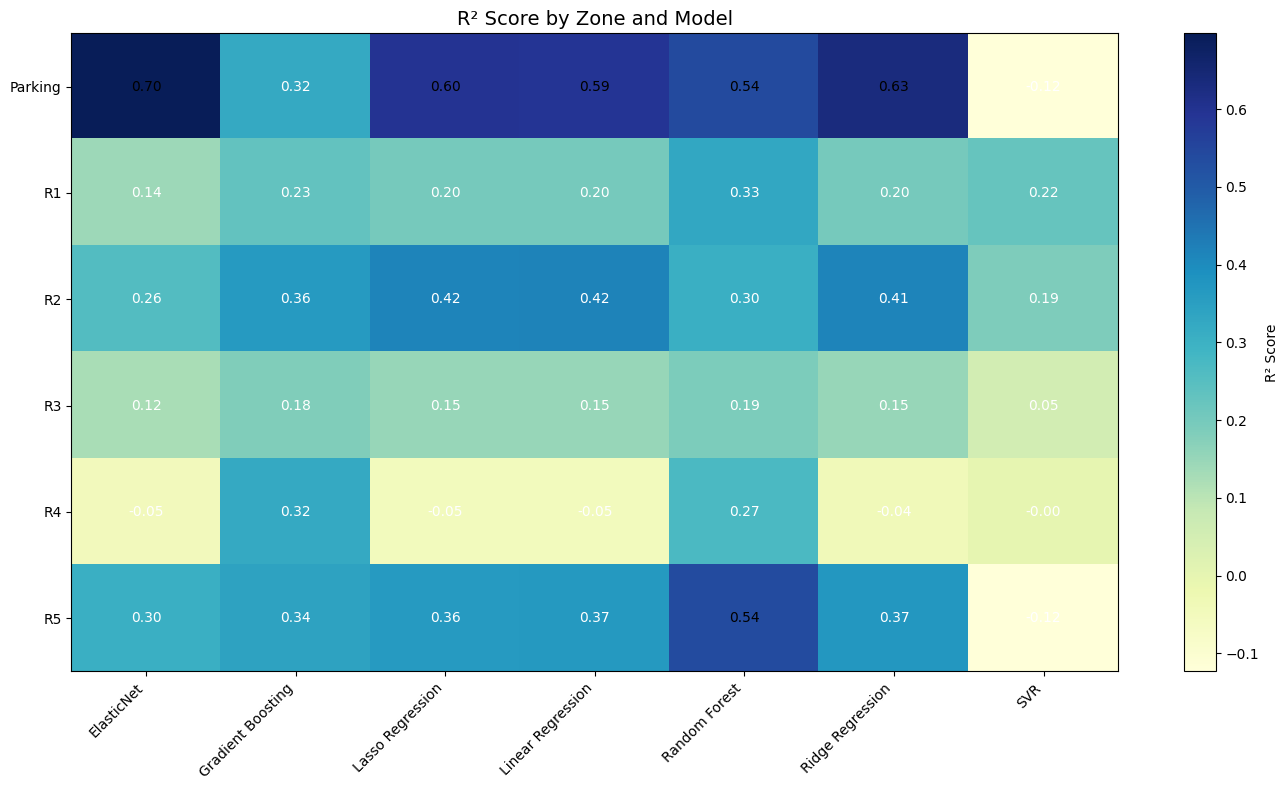

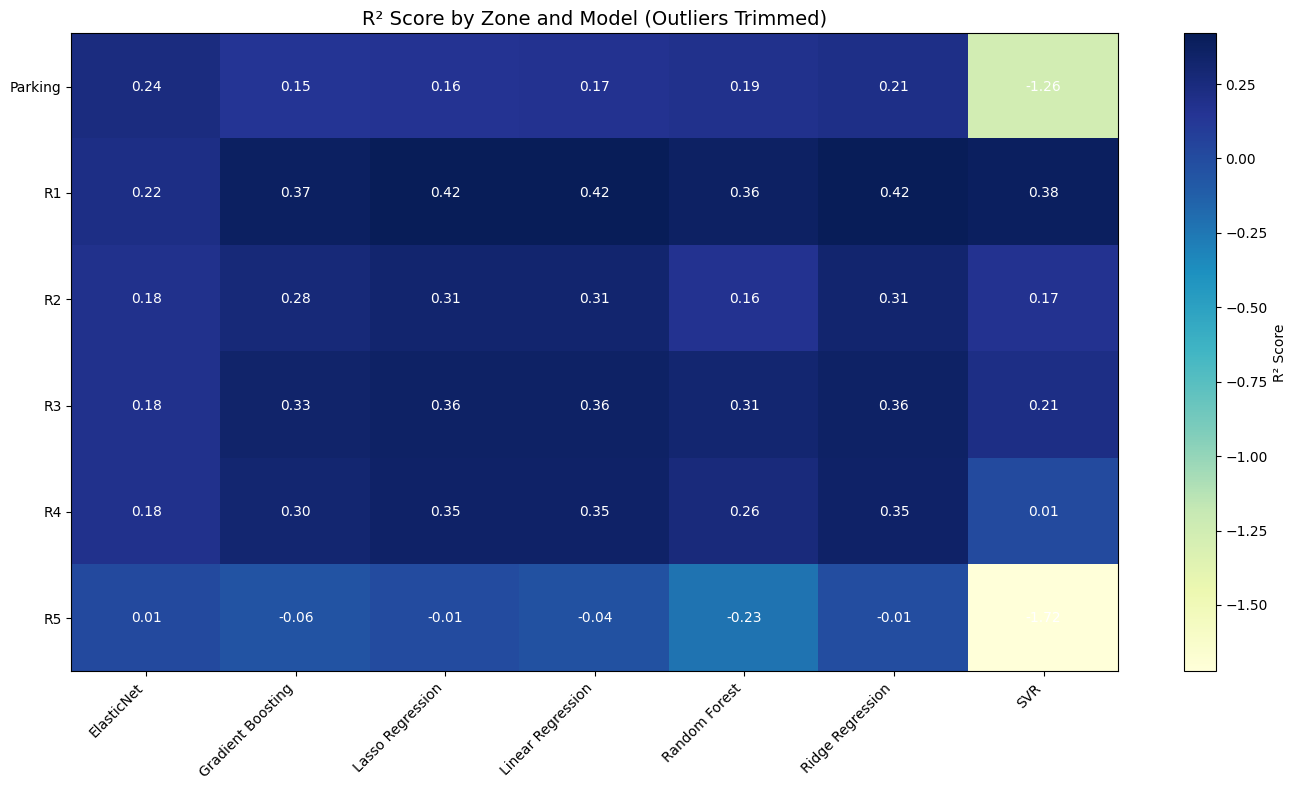

In [96]:
# THIS ONE


def trim_outliers(df_, lower_q=0.01, upper_q=0.99):
    """
    Remove outliers from the dataframe based on quantile ranges
    """
    if len(df_) < 4:  # Not enough data to trim meaningfully
        return df_

    return df_[
        df_["Property_Tax_Value"].between(
            df_["Property_Tax_Value"].quantile(lower_q),
            df_["Property_Tax_Value"].quantile(upper_q),
        )
        & df_["acreage"].between(
            df_["acreage"].quantile(lower_q),
            df_["acreage"].quantile(upper_q),
        )
    ]


def prepare_data(df, min_year=0, trim_outliers_flag=False, lower_q=0.01, upper_q=0.99):
    """
    Prepare data with zip code encoding for regression modeling
    Optionally trim outliers
    """

    df_encoded = df[df["Effective Year"] > min_year].copy()

    # Drop rows with missing required fields
    df_encoded = df_encoded.dropna(
        subset=["acreage", "zip_code", "Property_Tax_Value", "assigned_zoning_bucket"]
    )
    df_encoded["Parcel_age"] = 2025 - df_encoded["Effective Year"]

    # Trim outliers if requested
    if trim_outliers_flag:
        original_len = len(df_encoded)
        df_encoded = trim_outliers(df_encoded, lower_q, upper_q)
        trimmed_count = original_len - len(df_encoded)
        print(
            f"Trimmed {trimmed_count} outliers ({trimmed_count / original_len:.1%} of data)"
        )

    # One-hot encode zip_code
    zip_dummies = pd.get_dummies(df_encoded["zip_code"], prefix="zip")
    df_encoded = pd.concat([df_encoded, zip_dummies], axis=1)

    return df_encoded


def compare_regression_models(
    df,
    zone_prefixes,
    min_year=2015,
    trim_outliers_flag=False,
    lower_q=0.01,
    upper_q=0.99,
):
    """
    Compare different regression models using acreage and zip code as features
    """
    # Prepare data with zip code encoding
    df_encoded = prepare_data(
        df,
        min_year=min_year,
        trim_outliers_flag=trim_outliers_flag,
        lower_q=lower_q,
        upper_q=upper_q,
    )

    # Models to evaluate
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Lasso Regression": Lasso(alpha=0.1),
        "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
        "SVR": Pipeline(
            [("scaler", StandardScaler()), ("svr", LinearSVR(max_iter=10000))]
        ),
        "Random Forest": RandomForestRegressor(
            n_estimators=50, random_state=42, n_jobs=4
        ),
        "Gradient Boosting": GradientBoostingRegressor(
            n_estimators=50, random_state=42
        ),
    }

    # Skip NaN zone if present
    valid_zones = [zone for zone in zone_prefixes if not pd.isna(zone)]

    # Dictionary to store results
    results = {}

    # For each zone
    for zone in valid_zones:
        zone_data = df_encoded[df_encoded["assigned_zoning_bucket"] == zone]

        # Apply additional zone-specific outlier trimming if requested
        if trim_outliers_flag:
            original_zone_len = len(zone_data)
            zone_data = trim_outliers(zone_data, lower_q, upper_q)
            zone_trimmed_count = original_zone_len - len(zone_data)
            if zone_trimmed_count > 0:
                print(
                    f"  Zone {zone}: Trimmed {zone_trimmed_count} additional outliers ({zone_trimmed_count / original_zone_len:.1%} of zone data)"
                )

        # Skip if insufficient data (need at least 10 samples for meaningful results)
        # if len(zone_data) < 10:
        #     print(
        #         f"Skipping zone {zone} - insufficient data (only {len(zone_data)} samples)"
        #     )
        #     continue

        print(f"\nProcessing zone: {zone} (Data: {len(zone_data)} samples)")

        # Prepare features - using acreage and zip code dummy variables
        zip_columns = [col for col in zone_data.columns if col.startswith("zip_")]
        feature_columns = ["acreage"] + ["Parcel_age"] + zip_columns

        print("Features", feature_columns)

        X = zone_data[feature_columns].values
        y = zone_data["Property_Tax_Value"].values

        # Try to split data for validation - 70% train, 30% test
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42
            )

            zone_results = []

            # Evaluate each model
            for name, model in models.items():
                try:
                    # Train model
                    model.fit(X_train, y_train)

                    # Make predictions
                    y_pred = model.predict(X_test)

                    # Calculate metrics
                    r2 = r2_score(y_test, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mae = mean_absolute_error(y_test, y_pred)

                    # Cross validation for robustness (ensure we have enough folds)
                    cv_folds = min(
                        5, len(zone_data) // 3
                    )  # Ensure at least 3 samples per fold
                    if cv_folds >= 2:  # Need at least 2 folds
                        cv_scores = cross_val_score(
                            model, X, y, cv=cv_folds, scoring="r2"
                        )
                        cv_r2 = cv_scores.mean()
                    else:
                        cv_r2 = np.nan  # Cannot perform CV with too few samples

                    zone_results.append(
                        {
                            "zone": zone,
                            "model": name,
                            "r2_score": r2,
                            "cv_r2_score": cv_r2,
                            "rmse": rmse,
                            "mae": mae,
                            "samples": len(zone_data),
                            "num_features": X.shape[1],
                            "outliers_trimmed": trim_outliers_flag,
                        }
                    )

                    print(
                        f"  {name}: R² = {r2:.4f}, CV R² = {cv_r2:.4f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}"
                    )

                except Exception as e:
                    print(f"  Error with {name}: {str(e)}")

            results[zone] = zone_results

        except ValueError as e:
            print(f"  Error splitting data for zone {zone}: {str(e)}")

    return results


def summarize_results(results):
    """
    Summarize regression results and create visualizations
    """
    # Flatten results into a dataframe
    all_results = []
    for zone, models in results.items():
        all_results.extend(models)

    df_results = pd.DataFrame(all_results)

    # Print best model for each zone
    print("\n--- BEST MODEL FOR EACH ZONING BUCKET ---")
    for zone in df_results["zone"].unique():
        zone_df = df_results[df_results["zone"] == zone]

        # Find index of best model based on R²
        if not zone_df.empty and not all(pd.isna(zone_df["r2_score"])):
            best_idx = zone_df["r2_score"].idxmax()
            if pd.notna(best_idx):  # Ensure we have a valid index
                best_model = zone_df.loc[best_idx]
                outlier_status = (
                    "with outliers trimmed"
                    if best_model.get("outliers_trimmed", False)
                    else "all data"
                )
                print(
                    f"\nZONE: {zone} (Samples: {best_model['samples']}, Features: {best_model['num_features']}, {outlier_status})"
                )
                print(f"Best model: {best_model['model']}")
                print(f"R² Score: {best_model['r2_score']:.4f}")
                if pd.notna(best_model["cv_r2_score"]):
                    print(f"CV R² Score: {best_model['cv_r2_score']:.4f}")
                else:
                    print("CV R² Score: N/A (insufficient data for cross-validation)")
                print(f"RMSE: {best_model['rmse']:.2f}")
                print(f"MAE: {best_model['mae']:.2f}")

    # Plot R² comparison across zones and models
    for zone in df_results["zone"].unique():
        zone_df = df_results[df_results["zone"] == zone]

        if zone_df.empty:
            continue

        plt.figure(figsize=(12, 6))

        # Sort by R² score
        zone_df = zone_df.sort_values("r2_score", ascending=False)

        plt.bar(zone_df["model"], zone_df["r2_score"], alpha=0.7)
        plt.axhline(
            y=0.7, color="r", linestyle="--", label="R² = 0.7 (Good fit threshold)"
        )

        # Determine title suffix based on outlier trimming
        outlier_suffix = (
            " (Outliers Trimmed)"
            if zone_df.iloc[0].get("outliers_trimmed", False)
            else ""
        )
        plt.title(f"Model R² Comparison for Zone: {zone}{outlier_suffix}", fontsize=14)

        plt.xlabel("Model")
        plt.ylabel("R² Score")
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0, 1.0)
        plt.legend()
        plt.tight_layout()

        # Adjust filename based on outlier trimming
        outlier_filename = (
            "_trimmed" if zone_df.iloc[0].get("outliers_trimmed", False) else ""
        )
        plt.savefig(
            f"model_comparison_zone_{zone}_with_zip{outlier_filename}.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.close()

    # Only create heatmap if we have sufficient data
    if len(df_results["zone"].unique()) > 1 and len(df_results["model"].unique()) > 1:
        # Heatmap of R² scores
        pivot_r2 = df_results.pivot(index="zone", columns="model", values="r2_score")

        plt.figure(figsize=(14, 8))
        im = plt.imshow(pivot_r2, cmap="YlGnBu", aspect="auto")
        plt.colorbar(im, label="R² Score")

        # Determine title suffix based on outlier trimming
        outlier_suffix = (
            " (Outliers Trimmed)"
            if df_results.iloc[0].get("outliers_trimmed", False)
            else ""
        )
        plt.title(f"R² Score by Zone and Model{outlier_suffix}", fontsize=14)

        plt.xticks(
            np.arange(len(pivot_r2.columns)), pivot_r2.columns, rotation=45, ha="right"
        )
        plt.yticks(np.arange(len(pivot_r2.index)), pivot_r2.index)

        # Annotate cells with R² values
        for i in range(len(pivot_r2.index)):
            for j in range(len(pivot_r2.columns)):
                value = pivot_r2.iloc[i, j]
                if not pd.isna(value):
                    plt.text(
                        j,
                        i,
                        f"{value:.2f}",
                        ha="center",
                        va="center",
                        color="black" if value > 0.5 else "white",
                    )

        plt.tight_layout()

        # Adjust filename based on outlier trimming
        outlier_filename = (
            "_trimmed" if df_results.iloc[0].get("outliers_trimmed", False) else ""
        )
        plt.savefig(
            f"model_comparison_heatmap_with_zip{outlier_filename}.png",
            dpi=300,
            bbox_inches="tight",
        )

    return df_results


def run_complete_analysis(
    df,
    zone_prefixes,
    min_year=0,
    trim_outliers_flag=False,
    lower_q=0.01,
    upper_q=0.99,
):
    """
    Run the complete analysis pipeline and save results
    """
    outlier_str = (
        "with outlier trimming" if trim_outliers_flag else "without outlier trimming"
    )
    print(
        f"Starting regression model comparison with zip code as a feature ({outlier_str})..."
    )

    model_comparison_results = compare_regression_models(
        df,
        zone_prefixes,
        min_year=min_year,
        trim_outliers_flag=trim_outliers_flag,
        lower_q=lower_q,
        upper_q=upper_q,
    )

    print("\nGenerating summary and visualizations...")
    summary_df = summarize_results(model_comparison_results)

    # Export results to CSV with appropriate filename
    outlier_suffix = "_trimmed" if trim_outliers_flag else ""
    summary_df.to_csv(
        f"regression_model_comparison_with_zip{outlier_suffix}.csv", index=False
    )

    print(
        "\nAnalysis complete. Results saved to CSV and visualizations saved as PNG files."
    )

    return summary_df, model_comparison_results


# To execute:
# For analysis without outlier trimming:
# summary_df, model_results = run_complete_analysis(result, zone_prefixes)

# For analysis with outlier trimming:
# summary_df_trimmed, model_results_trimmed = run_complete_analysis(
#     result, zone_prefixes, trim_outliers_flag=True, lower_q=0.01, upper_q=0.99
# )


# To compare both approaches:
def compare_trimmed_vs_untrimmed():
    """Compare the results with and without outlier trimming"""
    # Run both analyses
    summary_df, _ = run_complete_analysis(
        result, zone_prefixes, trim_outliers_flag=False
    )
    summary_df_trimmed, _ = run_complete_analysis(
        result, zone_prefixes, trim_outliers_flag=True
    )

    # Add a column to identify trimmed vs untrimmed
    summary_df["data_type"] = "untrimmed"
    summary_df_trimmed["data_type"] = "trimmed"

    # Combine results
    combined_df = pd.concat([summary_df, summary_df_trimmed])

    # For each zone, compare the best model with and without trimming
    for zone in combined_df["zone"].unique():
        zone_data = combined_df[combined_df["zone"] == zone]

        # Get best model for each approach
        best_untrimmed = (
            zone_data[zone_data["data_type"] == "untrimmed"]
            .sort_values("r2_score", ascending=False)
            .iloc[0]
        )
        best_trimmed = (
            zone_data[zone_data["data_type"] == "trimmed"]
            .sort_values("r2_score", ascending=False)
            .iloc[0]
        )

        print(f"\nZone: {zone}")
        print(
            f"Best untrimmed: {best_untrimmed['model']} (R² = {best_untrimmed['r2_score']:.4f})"
        )
        print(
            f"Best trimmed: {best_trimmed['model']} (R² = {best_trimmed['r2_score']:.4f})"
        )
        print(
            f"Improvement with trimming: {best_trimmed['r2_score'] - best_untrimmed['r2_score']:.4f}"
        )

    return combined_df


combined_results = compare_trimmed_vs_untrimmed()
combined_results.to_csv("regression_comparison_trimmed_vs_untrimmed.csv", index=False)

Starting regression model comparison with zip code as a feature (without outlier trimming)...

Processing zone: R1 (Data: 412590 samples)
  Linear Regression: R² = 0.0248, CV R² = -0.2024, RMSE = 16740.30, MAE = 5828.33
  Ridge Regression: R² = 0.0248, CV R² = -0.2023, RMSE = 16740.23, MAE = 5828.28
  Lasso Regression: R² = 0.0248, CV R² = -0.2022, RMSE = 16740.20, MAE = 5828.21
  ElasticNet: R² = 0.0797, CV R² = -0.0863, RMSE = 16262.01, MAE = 5911.42
  SVR: R² = 0.0624, CV R² = 0.1311, RMSE = 16414.03, MAE = 5286.17
  Random Forest: R² = 0.4439, CV R² = 0.1621, RMSE = 12641.87, MAE = 4366.93
  Gradient Boosting: R² = 0.2539, CV R² = 0.2008, RMSE = 14642.67, MAE = 4651.84

Processing zone: R3 (Data: 102582 samples)
  Linear Regression: R² = 0.1289, CV R² = 0.0782, RMSE = 49990.48, MAE = 9350.61
  Ridge Regression: R² = 0.1289, CV R² = 0.0784, RMSE = 49990.59, MAE = 9350.16
  Lasso Regression: R² = 0.1289, CV R² = 0.0782, RMSE = 49990.51, MAE = 9350.43
  ElasticNet: R² = 0.1128, CV R² 

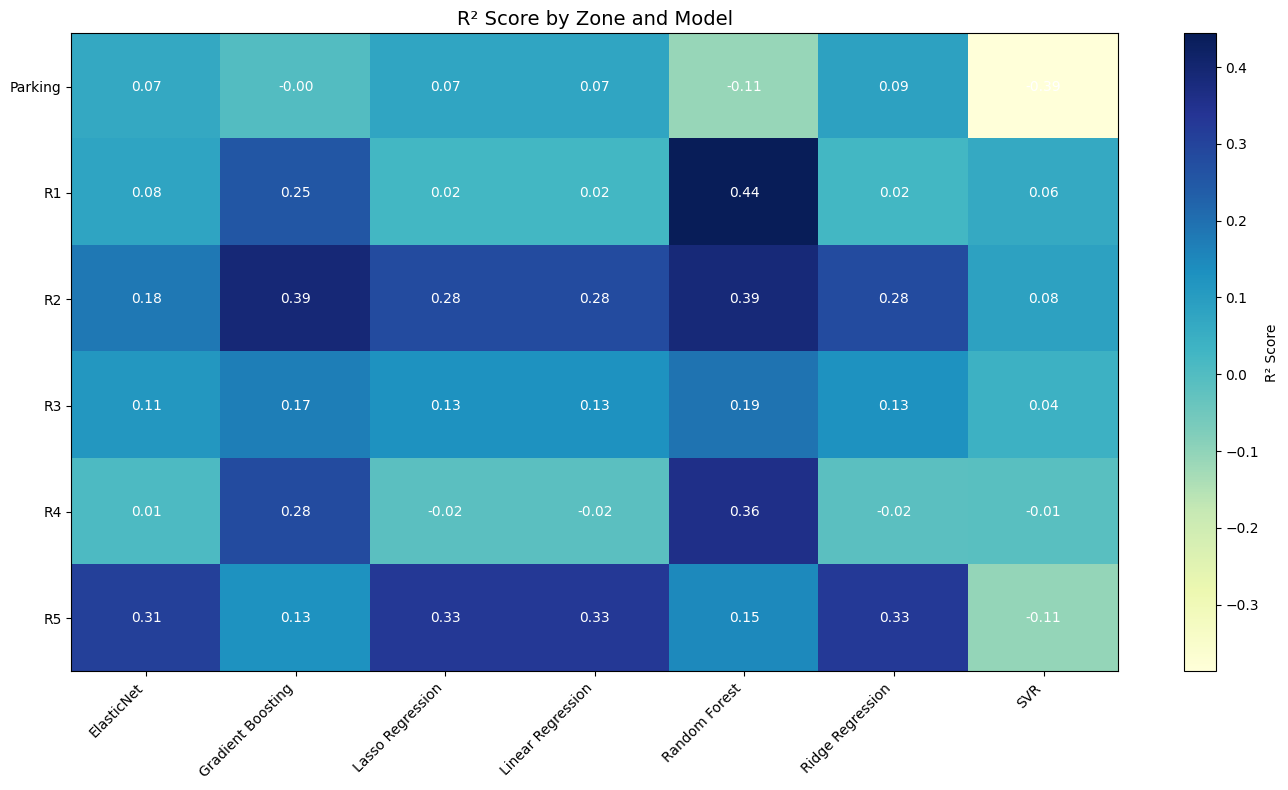

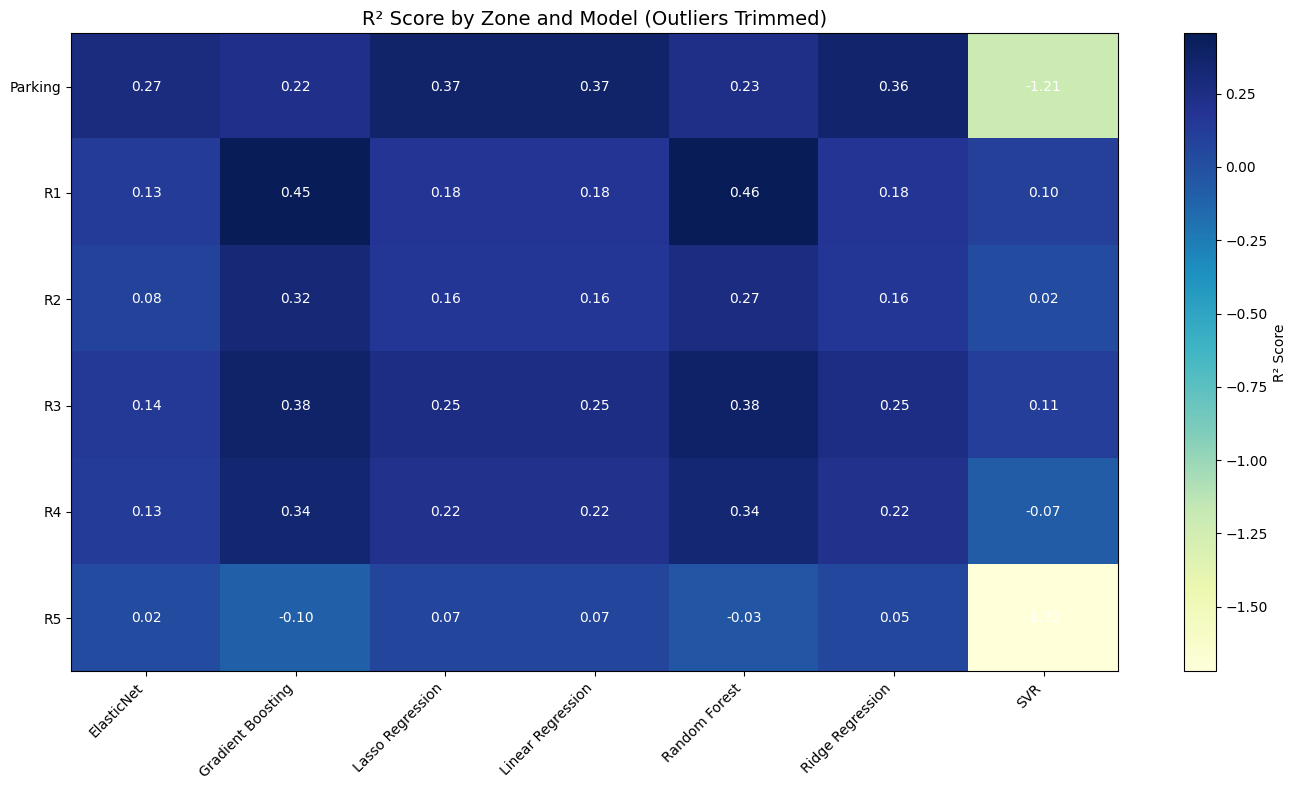

In [98]:
# Lat/Lon instead of zips!
warnings.filterwarnings("ignore")


def trim_outliers(df_, lower_q=0.01, upper_q=0.99):
    """
    Remove outliers from the dataframe based on quantile ranges
    """
    if len(df_) < 4:  # Not enough data to trim meaningfully
        return df_

    return df_[
        df_["Property_Tax_Value"].between(
            df_["Property_Tax_Value"].quantile(lower_q),
            df_["Property_Tax_Value"].quantile(upper_q),
        )
        & df_["acreage"].between(
            df_["acreage"].quantile(lower_q),
            df_["acreage"].quantile(upper_q),
        )
    ]


def prepare_data(df, min_year=0, trim_outliers_flag=False, lower_q=0.01, upper_q=0.99):
    """
    Prepare data with zip code encoding for regression modeling
    Optionally trim outliers
    """

    df_encoded = df[df["Effective Year"] > min_year].copy()

    # Drop rows with missing required fields
    df_encoded = df_encoded.dropna(
        subset=[
            "acreage",
            "Location Latitude",
            "Location Longitude",
            "Property_Tax_Value",
            "assigned_zoning_bucket",
        ]
    )
    df_encoded["Parcel_age"] = 2025 - df_encoded["Effective Year"]

    # Trim outliers if requested
    if trim_outliers_flag:
        original_len = len(df_encoded)
        df_encoded = trim_outliers(df_encoded, lower_q, upper_q)
        trimmed_count = original_len - len(df_encoded)
        print(
            f"Trimmed {trimmed_count} outliers ({trimmed_count / original_len:.1%} of data)"
        )

    # One-hot encode zip_code
    # zip_dummies = pd.get_dummies(df_encoded["zip_code"], prefix="zip")
    # df_encoded = pd.concat([df_encoded, zip_dummies], axis=1)

    return df_encoded


def compare_regression_models(
    df,
    zone_prefixes,
    min_year=2015,
    trim_outliers_flag=False,
    lower_q=0.01,
    upper_q=0.99,
):
    """
    Compare different regression models using acreage and zip code as features
    """
    # Prepare data with zip code encoding
    df_encoded = prepare_data(
        df,
        min_year=min_year,
        trim_outliers_flag=trim_outliers_flag,
        lower_q=lower_q,
        upper_q=upper_q,
    )

    # Models to evaluate
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Lasso Regression": Lasso(alpha=0.1),
        "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
        "SVR": Pipeline(
            [("scaler", StandardScaler()), ("svr", LinearSVR(max_iter=10000))]
        ),
        "Random Forest": RandomForestRegressor(
            n_estimators=50, random_state=42, n_jobs=4
        ),
        "Gradient Boosting": GradientBoostingRegressor(
            n_estimators=50, random_state=42
        ),
    }

    # Skip NaN zone if present
    valid_zones = [zone for zone in zone_prefixes if not pd.isna(zone)]

    # Dictionary to store results
    results = {}

    # For each zone
    for zone in valid_zones:
        zone_data = df_encoded[df_encoded["assigned_zoning_bucket"] == zone]

        # Apply additional zone-specific outlier trimming if requested
        if trim_outliers_flag:
            original_zone_len = len(zone_data)
            zone_data = trim_outliers(zone_data, lower_q, upper_q)
            zone_trimmed_count = original_zone_len - len(zone_data)
            if zone_trimmed_count > 0:
                print(
                    f"  Zone {zone}: Trimmed {zone_trimmed_count} additional outliers ({zone_trimmed_count / original_zone_len:.1%} of zone data)"
                )

        # Skip if insufficient data (need at least 10 samples for meaningful results)
        # if len(zone_data) < 10:
        #     print(
        #         f"Skipping zone {zone} - insufficient data (only {len(zone_data)} samples)"
        #     )
        #     continue

        print(f"\nProcessing zone: {zone} (Data: {len(zone_data)} samples)")

        # Prepare features - using acreage and zip code dummy variables
        # zip_columns = [col for col in zone_data.columns if col.startswith("zip_")]
        feature_columns = (
            ["acreage"]
            + ["Parcel_age"]
            + ["Location Latitude"]
            + ["Location Longitude"]
        )

        X = zone_data[feature_columns].values
        y = zone_data["Property_Tax_Value"].values

        # Try to split data for validation - 70% train, 30% test
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42
            )

            zone_results = []

            # Evaluate each model
            for name, model in models.items():
                try:
                    # Train model
                    model.fit(X_train, y_train)

                    # Make predictions
                    y_pred = model.predict(X_test)

                    # Calculate metrics
                    r2 = r2_score(y_test, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mae = mean_absolute_error(y_test, y_pred)

                    # Cross validation for robustness (ensure we have enough folds)
                    cv_folds = min(
                        5, len(zone_data) // 3
                    )  # Ensure at least 3 samples per fold
                    if cv_folds >= 2:  # Need at least 2 folds
                        cv_scores = cross_val_score(
                            model, X, y, cv=cv_folds, scoring="r2"
                        )
                        cv_r2 = cv_scores.mean()
                    else:
                        cv_r2 = np.nan  # Cannot perform CV with too few samples

                    zone_results.append(
                        {
                            "zone": zone,
                            "model": name,
                            "r2_score": r2,
                            "cv_r2_score": cv_r2,
                            "rmse": rmse,
                            "mae": mae,
                            "samples": len(zone_data),
                            "num_features": X.shape[1],
                            "outliers_trimmed": trim_outliers_flag,
                        }
                    )

                    print(
                        f"  {name}: R² = {r2:.4f}, CV R² = {cv_r2:.4f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}"
                    )

                except Exception as e:
                    print(f"  Error with {name}: {str(e)}")

            results[zone] = zone_results

        except ValueError as e:
            print(f"  Error splitting data for zone {zone}: {str(e)}")

    return results


def summarize_results(results):
    """
    Summarize regression results and create visualizations
    """
    # Flatten results into a dataframe
    all_results = []
    for zone, models in results.items():
        all_results.extend(models)

    df_results = pd.DataFrame(all_results)

    # Print best model for each zone
    print("\n--- BEST MODEL FOR EACH ZONING BUCKET ---")
    for zone in df_results["zone"].unique():
        zone_df = df_results[df_results["zone"] == zone]

        # Find index of best model based on R²
        if not zone_df.empty and not all(pd.isna(zone_df["r2_score"])):
            best_idx = zone_df["r2_score"].idxmax()
            if pd.notna(best_idx):  # Ensure we have a valid index
                best_model = zone_df.loc[best_idx]
                outlier_status = (
                    "with outliers trimmed"
                    if best_model.get("outliers_trimmed", False)
                    else "all data"
                )
                print(
                    f"\nZONE: {zone} (Samples: {best_model['samples']}, Features: {best_model['num_features']}, {outlier_status})"
                )
                print(f"Best model: {best_model['model']}")
                print(f"R² Score: {best_model['r2_score']:.4f}")
                if pd.notna(best_model["cv_r2_score"]):
                    print(f"CV R² Score: {best_model['cv_r2_score']:.4f}")
                else:
                    print("CV R² Score: N/A (insufficient data for cross-validation)")
                print(f"RMSE: {best_model['rmse']:.2f}")
                print(f"MAE: {best_model['mae']:.2f}")

    # Plot R² comparison across zones and models
    for zone in df_results["zone"].unique():
        zone_df = df_results[df_results["zone"] == zone]

        if zone_df.empty:
            continue

        plt.figure(figsize=(12, 6))

        # Sort by R² score
        zone_df = zone_df.sort_values("r2_score", ascending=False)

        plt.bar(zone_df["model"], zone_df["r2_score"], alpha=0.7)
        plt.axhline(
            y=0.7, color="r", linestyle="--", label="R² = 0.7 (Good fit threshold)"
        )

        # Determine title suffix based on outlier trimming
        outlier_suffix = (
            " (Outliers Trimmed)"
            if zone_df.iloc[0].get("outliers_trimmed", False)
            else ""
        )
        plt.title(f"Model R² Comparison for Zone: {zone}{outlier_suffix}", fontsize=14)

        plt.xlabel("Model")
        plt.ylabel("R² Score")
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0, 1.0)
        plt.legend()
        plt.tight_layout()

        # Adjust filename based on outlier trimming
        outlier_filename = (
            "_trimmed" if zone_df.iloc[0].get("outliers_trimmed", False) else ""
        )
        plt.savefig(
            f"model_comparison_zone_{zone}_with_zip{outlier_filename}.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.close()

    # Only create heatmap if we have sufficient data
    if len(df_results["zone"].unique()) > 1 and len(df_results["model"].unique()) > 1:
        # Heatmap of R² scores
        pivot_r2 = df_results.pivot(index="zone", columns="model", values="r2_score")

        plt.figure(figsize=(14, 8))
        im = plt.imshow(pivot_r2, cmap="YlGnBu", aspect="auto")
        plt.colorbar(im, label="R² Score")

        # Determine title suffix based on outlier trimming
        outlier_suffix = (
            " (Outliers Trimmed)"
            if df_results.iloc[0].get("outliers_trimmed", False)
            else ""
        )
        plt.title(f"R² Score by Zone and Model{outlier_suffix}", fontsize=14)

        plt.xticks(
            np.arange(len(pivot_r2.columns)), pivot_r2.columns, rotation=45, ha="right"
        )
        plt.yticks(np.arange(len(pivot_r2.index)), pivot_r2.index)

        # Annotate cells with R² values
        for i in range(len(pivot_r2.index)):
            for j in range(len(pivot_r2.columns)):
                value = pivot_r2.iloc[i, j]
                if not pd.isna(value):
                    plt.text(
                        j,
                        i,
                        f"{value:.2f}",
                        ha="center",
                        va="center",
                        color="black" if value > 0.5 else "white",
                    )

        plt.tight_layout()

        # Adjust filename based on outlier trimming
        outlier_filename = (
            "_trimmed" if df_results.iloc[0].get("outliers_trimmed", False) else ""
        )
        plt.savefig(
            f"model_comparison_heatmap_with_zip{outlier_filename}.png",
            dpi=300,
            bbox_inches="tight",
        )

    return df_results


def run_complete_analysis(
    df,
    zone_prefixes,
    min_year=0,
    trim_outliers_flag=False,
    lower_q=0.01,
    upper_q=0.99,
):
    """
    Run the complete analysis pipeline and save results
    """
    outlier_str = (
        "with outlier trimming" if trim_outliers_flag else "without outlier trimming"
    )
    print(
        f"Starting regression model comparison with zip code as a feature ({outlier_str})..."
    )

    model_comparison_results = compare_regression_models(
        df,
        zone_prefixes,
        min_year=min_year,
        trim_outliers_flag=trim_outliers_flag,
        lower_q=lower_q,
        upper_q=upper_q,
    )

    print("\nGenerating summary and visualizations...")
    summary_df = summarize_results(model_comparison_results)

    # Export results to CSV with appropriate filename
    outlier_suffix = "_trimmed" if trim_outliers_flag else ""
    summary_df.to_csv(
        f"regression_model_comparison_with_zip{outlier_suffix}.csv", index=False
    )

    print(
        "\nAnalysis complete. Results saved to CSV and visualizations saved as PNG files."
    )

    return summary_df, model_comparison_results


# To execute:
# For analysis without outlier trimming:
# summary_df, model_results = run_complete_analysis(result, zone_prefixes)

# For analysis with outlier trimming:
# summary_df_trimmed, model_results_trimmed = run_complete_analysis(
#     result, zone_prefixes, trim_outliers_flag=True, lower_q=0.01, upper_q=0.99
# )


# To compare both approaches:
def compare_trimmed_vs_untrimmed():
    """Compare the results with and without outlier trimming"""
    # Run both analyses
    summary_df, _ = run_complete_analysis(
        result, zone_prefixes, trim_outliers_flag=False
    )
    summary_df_trimmed, _ = run_complete_analysis(
        result, zone_prefixes, trim_outliers_flag=True
    )

    # Add a column to identify trimmed vs untrimmed
    summary_df["data_type"] = "untrimmed"
    summary_df_trimmed["data_type"] = "trimmed"

    # Combine results
    combined_df = pd.concat([summary_df, summary_df_trimmed])

    # For each zone, compare the best model with and without trimming
    for zone in combined_df["zone"].unique():
        zone_data = combined_df[combined_df["zone"] == zone]

        # Get best model for each approach
        best_untrimmed = (
            zone_data[zone_data["data_type"] == "untrimmed"]
            .sort_values("r2_score", ascending=False)
            .iloc[0]
        )
        best_trimmed = (
            zone_data[zone_data["data_type"] == "trimmed"]
            .sort_values("r2_score", ascending=False)
            .iloc[0]
        )

        print(f"\nZone: {zone}")
        print(
            f"Best untrimmed: {best_untrimmed['model']} (R² = {best_untrimmed['r2_score']:.4f})"
        )
        print(
            f"Best trimmed: {best_trimmed['model']} (R² = {best_trimmed['r2_score']:.4f})"
        )
        print(
            f"Improvement with trimming: {best_trimmed['r2_score'] - best_untrimmed['r2_score']:.4f}"
        )

    return combined_df


combined_results = compare_trimmed_vs_untrimmed()
combined_results.to_csv("regression_comparison_trimmed_vs_untrimmed.csv", index=False)

Starting regression model comparison with zip code as a feature (without outlier trimming)...

Processing zone: R1 (Data: 14571 samples)
  Linear Regression: R² = 0.2149, CV R² = -1.2628, RMSE = 32865.77, MAE = 13656.43
  Ridge Regression: R² = 0.2149, CV R² = -1.2528, RMSE = 32866.53, MAE = 13645.05
  Lasso Regression: R² = 0.2149, CV R² = -1.2627, RMSE = 32865.78, MAE = 13656.20
  ElasticNet: R² = 0.1538, CV R² = -0.8790, RMSE = 34121.42, MAE = 14709.32
  SVR: R² = -0.1266, CV R² = -0.1979, RMSE = 39371.51, MAE = 14668.10
  Random Forest: R² = 0.5614, CV R² = 0.1703, RMSE = 24565.77, MAE = 7917.90
  Gradient Boosting: R² = 0.5351, CV R² = 0.0527, RMSE = 25291.61, MAE = 8952.85

Processing zone: R3 (Data: 5177 samples)
  Linear Regression: R² = 0.1956, CV R² = 0.1792, RMSE = 49813.16, MAE = 14594.84
  Ridge Regression: R² = 0.1954, CV R² = 0.1818, RMSE = 49819.09, MAE = 14567.07
  Lasso Regression: R² = 0.1956, CV R² = 0.1792, RMSE = 49813.18, MAE = 14594.55
  ElasticNet: R² = 0.1518,

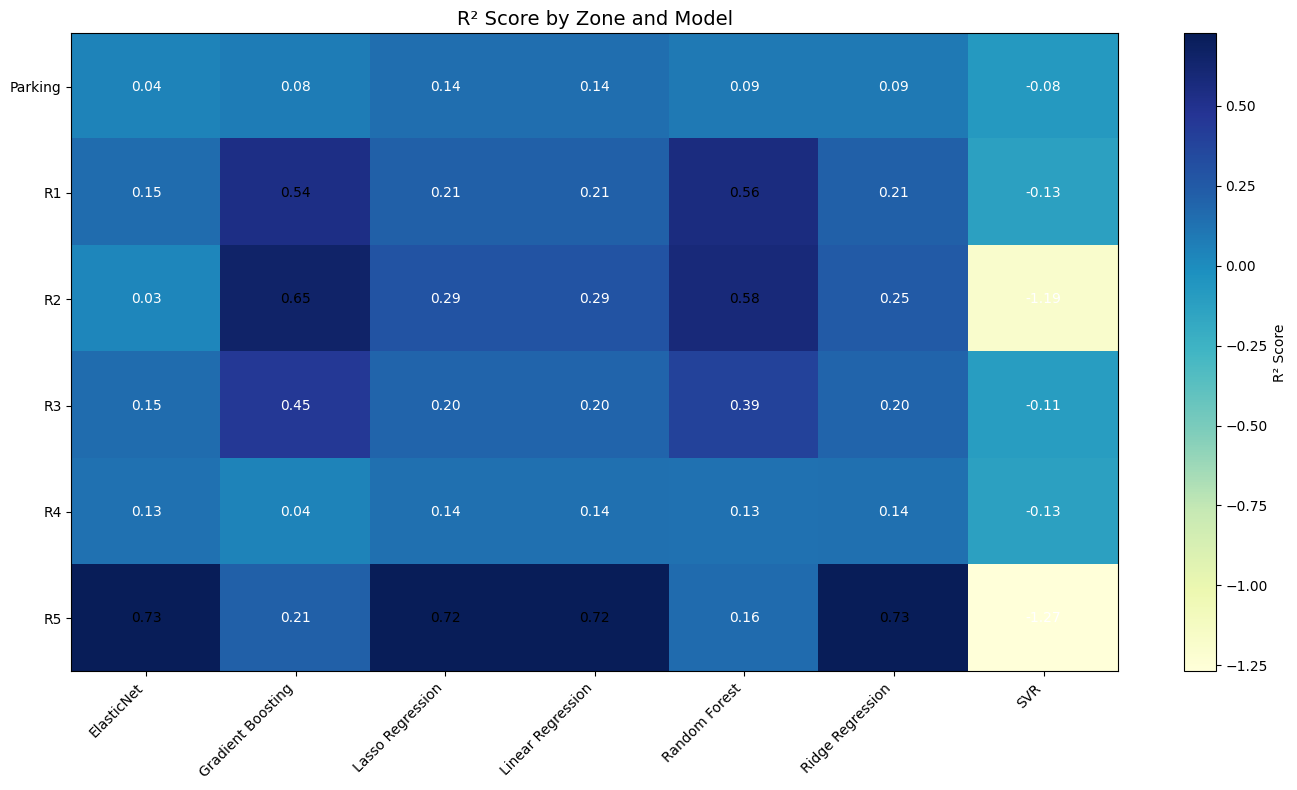

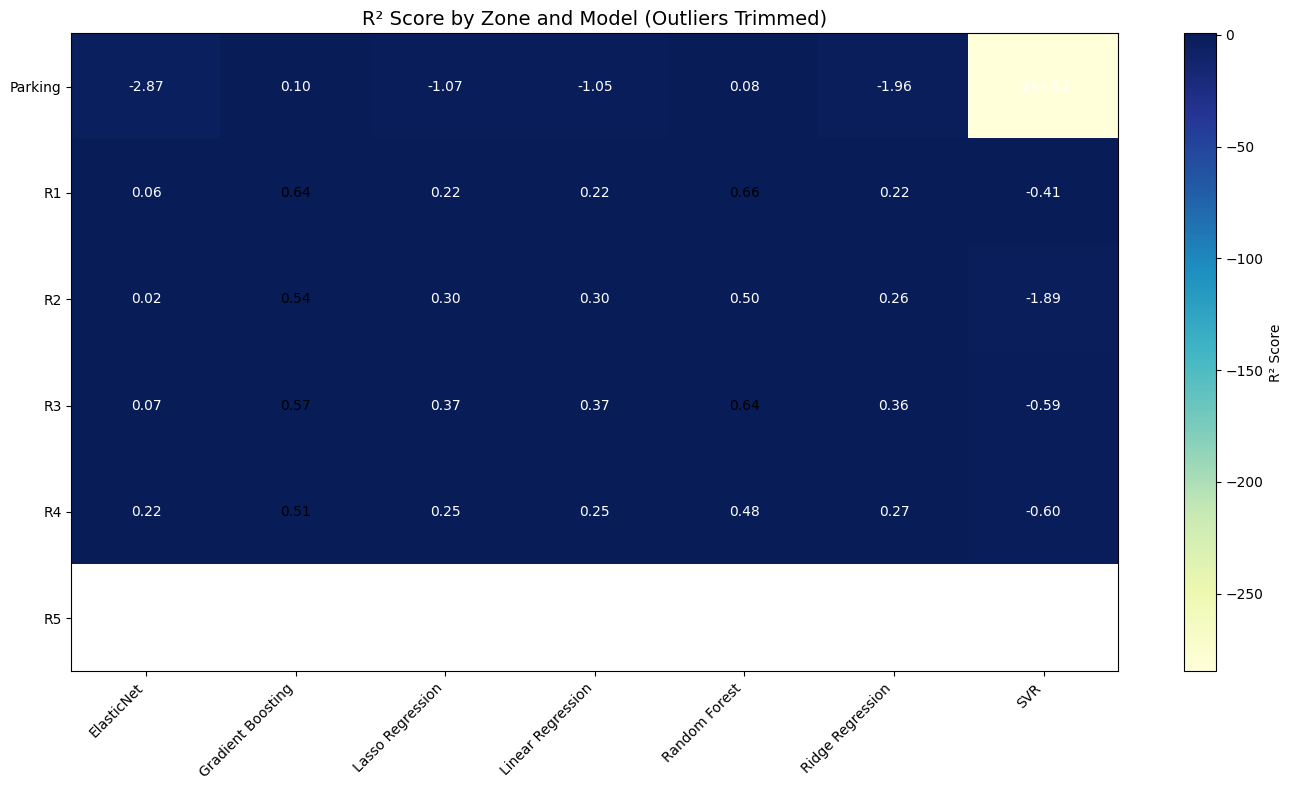

In [100]:
# Lat/Lon instead of zips!
warnings.filterwarnings("ignore")


def trim_outliers(df_, lower_q=0.01, upper_q=0.99):
    """
    Remove outliers from the dataframe based on quantile ranges
    """
    if len(df_) < 4:  # Not enough data to trim meaningfully
        return df_

    return df_[
        df_["Property_Tax_Value"].between(
            df_["Property_Tax_Value"].quantile(lower_q),
            df_["Property_Tax_Value"].quantile(upper_q),
        )
        & df_["acreage"].between(
            df_["acreage"].quantile(lower_q),
            df_["acreage"].quantile(upper_q),
        )
    ]


def prepare_data(df, min_year=0, trim_outliers_flag=False, lower_q=0.01, upper_q=0.99):
    """
    Prepare data with zip code encoding for regression modeling
    Optionally trim outliers
    """

    df_encoded = df[df["Effective Year"] > min_year].copy()

    # Drop rows with missing required fields
    df_encoded = df_encoded.dropna(
        subset=[
            "acreage",
            "Location Latitude",
            "Location Longitude",
            "Property_Tax_Value",
            "assigned_zoning_bucket",
        ]
    )
    df_encoded["Parcel_age"] = 2025 - df_encoded["Effective Year"]

    # Trim outliers if requested
    if trim_outliers_flag:
        original_len = len(df_encoded)
        df_encoded = trim_outliers(df_encoded, lower_q, upper_q)
        trimmed_count = original_len - len(df_encoded)
        print(
            f"Trimmed {trimmed_count} outliers ({trimmed_count / original_len:.1%} of data)"
        )

    # One-hot encode zip_code
    # zip_dummies = pd.get_dummies(df_encoded["zip_code"], prefix="zip")
    # df_encoded = pd.concat([df_encoded, zip_dummies], axis=1)

    return df_encoded


def compare_regression_models(
    df,
    zone_prefixes,
    min_year=2015,
    trim_outliers_flag=False,
    lower_q=0.01,
    upper_q=0.99,
):
    """
    Compare different regression models using acreage and zip code as features
    """
    # Prepare data with zip code encoding
    df_encoded = prepare_data(
        df,
        min_year=min_year,
        trim_outliers_flag=trim_outliers_flag,
        lower_q=lower_q,
        upper_q=upper_q,
    )

    # Models to evaluate
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Lasso Regression": Lasso(alpha=0.1),
        "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
        "SVR": Pipeline(
            [("scaler", StandardScaler()), ("svr", LinearSVR(max_iter=10000))]
        ),
        "Random Forest": RandomForestRegressor(
            n_estimators=50, random_state=42, n_jobs=4
        ),
        "Gradient Boosting": GradientBoostingRegressor(
            n_estimators=50, random_state=42
        ),
    }

    # Skip NaN zone if present
    valid_zones = [zone for zone in zone_prefixes if not pd.isna(zone)]

    # Dictionary to store results
    results = {}

    # For each zone
    for zone in valid_zones:
        zone_data = df_encoded[df_encoded["assigned_zoning_bucket"] == zone]

        # Apply additional zone-specific outlier trimming if requested
        if trim_outliers_flag:
            original_zone_len = len(zone_data)
            zone_data = trim_outliers(zone_data, lower_q, upper_q)
            zone_trimmed_count = original_zone_len - len(zone_data)
            if zone_trimmed_count > 0:
                print(
                    f"  Zone {zone}: Trimmed {zone_trimmed_count} additional outliers ({zone_trimmed_count / original_zone_len:.1%} of zone data)"
                )

        # Skip if insufficient data (need at least 10 samples for meaningful results)
        # if len(zone_data) < 10:
        #     print(
        #         f"Skipping zone {zone} - insufficient data (only {len(zone_data)} samples)"
        #     )
        #     continue

        print(f"\nProcessing zone: {zone} (Data: {len(zone_data)} samples)")

        # Prepare features - using acreage and zip code dummy variables
        # zip_columns = [col for col in zone_data.columns if col.startswith("zip_")]
        feature_columns = ["acreage"] + ["Location Latitude"] + ["Location Longitude"]

        X = zone_data[feature_columns].values
        y = zone_data["Property_Tax_Value"].values

        # Try to split data for validation - 70% train, 30% test
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42
            )

            zone_results = []

            # Evaluate each model
            for name, model in models.items():
                try:
                    # Train model
                    model.fit(X_train, y_train)

                    # Make predictions
                    y_pred = model.predict(X_test)

                    # Calculate metrics
                    r2 = r2_score(y_test, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mae = mean_absolute_error(y_test, y_pred)

                    # Cross validation for robustness (ensure we have enough folds)
                    cv_folds = min(
                        5, len(zone_data) // 3
                    )  # Ensure at least 3 samples per fold
                    if cv_folds >= 2:  # Need at least 2 folds
                        cv_scores = cross_val_score(
                            model, X, y, cv=cv_folds, scoring="r2"
                        )
                        cv_r2 = cv_scores.mean()
                    else:
                        cv_r2 = np.nan  # Cannot perform CV with too few samples

                    zone_results.append(
                        {
                            "zone": zone,
                            "model": name,
                            "r2_score": r2,
                            "cv_r2_score": cv_r2,
                            "rmse": rmse,
                            "mae": mae,
                            "samples": len(zone_data),
                            "num_features": X.shape[1],
                            "outliers_trimmed": trim_outliers_flag,
                        }
                    )

                    print(
                        f"  {name}: R² = {r2:.4f}, CV R² = {cv_r2:.4f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}"
                    )

                except Exception as e:
                    print(f"  Error with {name}: {str(e)}")

            results[zone] = zone_results

        except ValueError as e:
            print(f"  Error splitting data for zone {zone}: {str(e)}")

    return results


def summarize_results(results):
    """
    Summarize regression results and create visualizations
    """
    # Flatten results into a dataframe
    all_results = []
    for zone, models in results.items():
        all_results.extend(models)

    df_results = pd.DataFrame(all_results)

    # Print best model for each zone
    print("\n--- BEST MODEL FOR EACH ZONING BUCKET ---")
    for zone in df_results["zone"].unique():
        zone_df = df_results[df_results["zone"] == zone]

        # Find index of best model based on R²
        if not zone_df.empty and not all(pd.isna(zone_df["r2_score"])):
            best_idx = zone_df["r2_score"].idxmax()
            if pd.notna(best_idx):  # Ensure we have a valid index
                best_model = zone_df.loc[best_idx]
                outlier_status = (
                    "with outliers trimmed"
                    if best_model.get("outliers_trimmed", False)
                    else "all data"
                )
                print(
                    f"\nZONE: {zone} (Samples: {best_model['samples']}, Features: {best_model['num_features']}, {outlier_status})"
                )
                print(f"Best model: {best_model['model']}")
                print(f"R² Score: {best_model['r2_score']:.4f}")
                if pd.notna(best_model["cv_r2_score"]):
                    print(f"CV R² Score: {best_model['cv_r2_score']:.4f}")
                else:
                    print("CV R² Score: N/A (insufficient data for cross-validation)")
                print(f"RMSE: {best_model['rmse']:.2f}")
                print(f"MAE: {best_model['mae']:.2f}")

    # Plot R² comparison across zones and models
    for zone in df_results["zone"].unique():
        zone_df = df_results[df_results["zone"] == zone]

        if zone_df.empty:
            continue

        plt.figure(figsize=(12, 6))

        # Sort by R² score
        zone_df = zone_df.sort_values("r2_score", ascending=False)

        plt.bar(zone_df["model"], zone_df["r2_score"], alpha=0.7)
        plt.axhline(
            y=0.7, color="r", linestyle="--", label="R² = 0.7 (Good fit threshold)"
        )

        # Determine title suffix based on outlier trimming
        outlier_suffix = (
            " (Outliers Trimmed)"
            if zone_df.iloc[0].get("outliers_trimmed", False)
            else ""
        )
        plt.title(f"Model R² Comparison for Zone: {zone}{outlier_suffix}", fontsize=14)

        plt.xlabel("Model")
        plt.ylabel("R² Score")
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0, 1.0)
        plt.legend()
        plt.tight_layout()

        # Adjust filename based on outlier trimming
        outlier_filename = (
            "_trimmed" if zone_df.iloc[0].get("outliers_trimmed", False) else ""
        )
        plt.savefig(
            f"model_comparison_zone_{zone}_with_zip{outlier_filename}.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.close()

    # Only create heatmap if we have sufficient data
    if len(df_results["zone"].unique()) > 1 and len(df_results["model"].unique()) > 1:
        # Heatmap of R² scores
        pivot_r2 = df_results.pivot(index="zone", columns="model", values="r2_score")

        plt.figure(figsize=(14, 8))
        im = plt.imshow(pivot_r2, cmap="YlGnBu", aspect="auto")
        plt.colorbar(im, label="R² Score")

        # Determine title suffix based on outlier trimming
        outlier_suffix = (
            " (Outliers Trimmed)"
            if df_results.iloc[0].get("outliers_trimmed", False)
            else ""
        )
        plt.title(f"R² Score by Zone and Model{outlier_suffix}", fontsize=14)

        plt.xticks(
            np.arange(len(pivot_r2.columns)), pivot_r2.columns, rotation=45, ha="right"
        )
        plt.yticks(np.arange(len(pivot_r2.index)), pivot_r2.index)

        # Annotate cells with R² values
        for i in range(len(pivot_r2.index)):
            for j in range(len(pivot_r2.columns)):
                value = pivot_r2.iloc[i, j]
                if not pd.isna(value):
                    plt.text(
                        j,
                        i,
                        f"{value:.2f}",
                        ha="center",
                        va="center",
                        color="black" if value > 0.5 else "white",
                    )

        plt.tight_layout()

        # Adjust filename based on outlier trimming
        outlier_filename = (
            "_trimmed" if df_results.iloc[0].get("outliers_trimmed", False) else ""
        )
        plt.savefig(
            f"model_comparison_heatmap_with_zip{outlier_filename}.png",
            dpi=300,
            bbox_inches="tight",
        )

    return df_results


def run_complete_analysis(
    df,
    zone_prefixes,
    min_year=0,
    trim_outliers_flag=False,
    lower_q=0.01,
    upper_q=0.99,
):
    """
    Run the complete analysis pipeline and save results
    """
    outlier_str = (
        "with outlier trimming" if trim_outliers_flag else "without outlier trimming"
    )
    print(
        f"Starting regression model comparison with zip code as a feature ({outlier_str})..."
    )

    model_comparison_results = compare_regression_models(
        df,
        zone_prefixes,
        min_year=min_year,
        trim_outliers_flag=trim_outliers_flag,
        lower_q=lower_q,
        upper_q=upper_q,
    )

    print("\nGenerating summary and visualizations...")
    summary_df = summarize_results(model_comparison_results)

    # Export results to CSV with appropriate filename
    outlier_suffix = "_trimmed" if trim_outliers_flag else ""
    summary_df.to_csv(
        f"regression_model_comparison_with_zip{outlier_suffix}.csv", index=False
    )

    print(
        "\nAnalysis complete. Results saved to CSV and visualizations saved as PNG files."
    )

    return summary_df, model_comparison_results


# To execute:
# For analysis without outlier trimming:
# summary_df, model_results = run_complete_analysis(result, zone_prefixes)

# For analysis with outlier trimming:
# summary_df_trimmed, model_results_trimmed = run_complete_analysis(
#     result, zone_prefixes, trim_outliers_flag=True, lower_q=0.01, upper_q=0.99
# )


# To compare both approaches:
def compare_trimmed_vs_untrimmed():
    """Compare the results with and without outlier trimming"""
    # Run both analyses
    summary_df, _ = run_complete_analysis(
        result, zone_prefixes, trim_outliers_flag=False, min_year=2015
    )
    summary_df_trimmed, _ = run_complete_analysis(
        result, zone_prefixes, trim_outliers_flag=True, min_year=2015
    )

    # Add a column to identify trimmed vs untrimmed
    summary_df["data_type"] = "untrimmed"
    summary_df_trimmed["data_type"] = "trimmed"

    # Combine results
    combined_df = pd.concat([summary_df, summary_df_trimmed])

    # For each zone, compare the best model with and without trimming
    for zone in combined_df["zone"].unique():
        zone_data = combined_df[combined_df["zone"] == zone]

        # Get best model for each approach
        best_untrimmed = (
            zone_data[zone_data["data_type"] == "untrimmed"]
            .sort_values("r2_score", ascending=False)
            .iloc[0]
        )
        best_trimmed = (
            zone_data[zone_data["data_type"] == "trimmed"]
            .sort_values("r2_score", ascending=False)
            .iloc[0]
        )

        print(f"\nZone: {zone}")
        print(
            f"Best untrimmed: {best_untrimmed['model']} (R² = {best_untrimmed['r2_score']:.4f})"
        )
        print(
            f"Best trimmed: {best_trimmed['model']} (R² = {best_trimmed['r2_score']:.4f})"
        )
        print(
            f"Improvement with trimming: {best_trimmed['r2_score'] - best_untrimmed['r2_score']:.4f}"
        )

    return combined_df


combined_results = compare_trimmed_vs_untrimmed()
combined_results.to_csv("regression_comparison_trimmed_vs_untrimmed.csv", index=False)

Starting regression model comparison with zip code as a feature (without outlier trimming)...

Processing zone: R1 (Data: 14571 samples)
  Linear Regression: R² = 0.1740, CV R² = -1.3366, RMSE = 33711.52, MAE = 14758.08
  Ridge Regression: R² = 0.1740, CV R² = -1.3353, RMSE = 33712.40, MAE = 14758.60
  Lasso Regression: R² = 0.1740, CV R² = -1.3366, RMSE = 33711.54, MAE = 14758.09
  ElasticNet: R² = 0.1434, CV R² = -0.9655, RMSE = 34329.79, MAE = 15015.38
  SVR: R² = -0.1326, CV R² = -0.2194, RMSE = 39475.22, MAE = 14778.07
  Random Forest: R² = -0.1232, CV R² = -3.4939, RMSE = 39312.45, MAE = 15301.09
  Gradient Boosting: R² = -0.0797, CV R² = -2.0995, RMSE = 38542.23, MAE = 14942.90

Processing zone: R3 (Data: 5177 samples)
  Linear Regression: R² = 0.1928, CV R² = 0.2113, RMSE = 49900.48, MAE = 14310.69
  Ridge Regression: R² = 0.1925, CV R² = 0.2116, RMSE = 49908.60, MAE = 14317.90
  Lasso Regression: R² = 0.1928, CV R² = 0.2113, RMSE = 49900.52, MAE = 14310.73
  ElasticNet: R² = 0

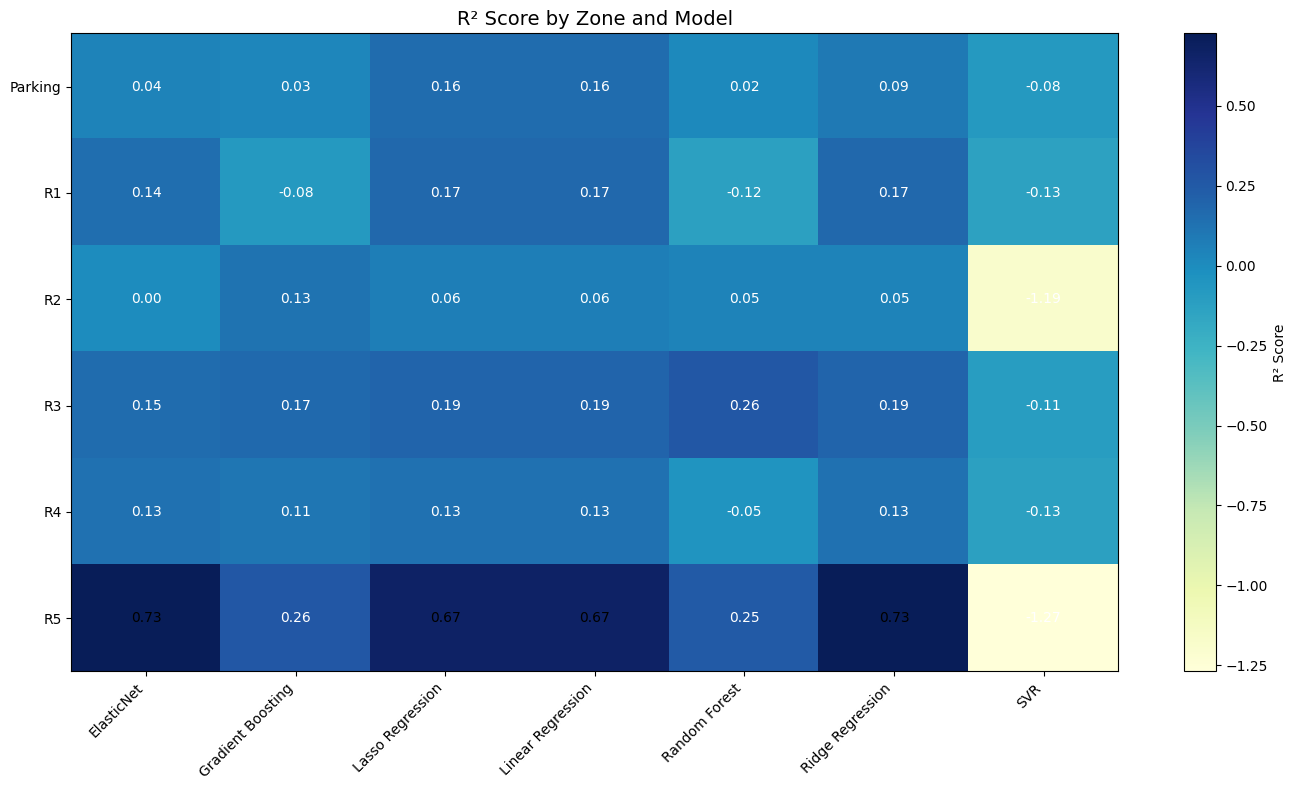

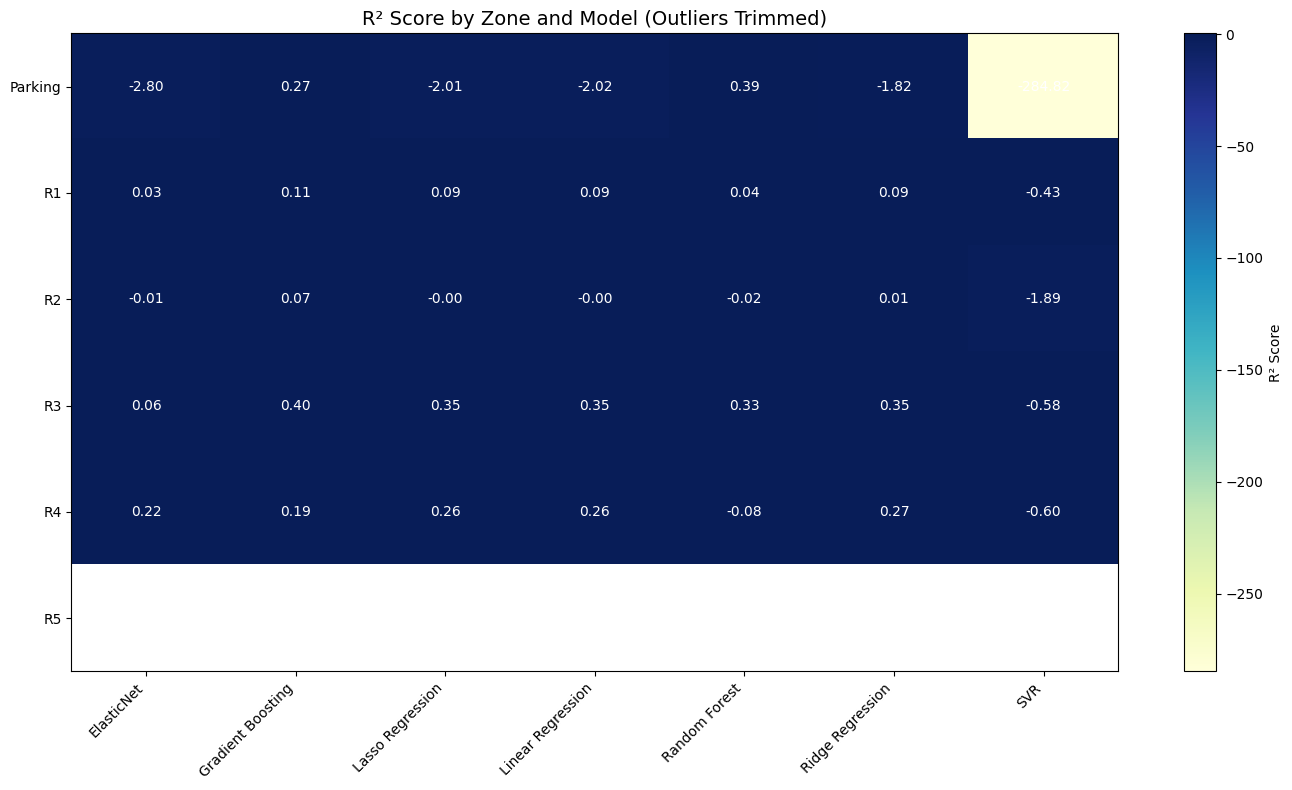

In [101]:
# Lat/Lon instead of zips!
warnings.filterwarnings("ignore")


def trim_outliers(df_, lower_q=0.01, upper_q=0.99):
    """
    Remove outliers from the dataframe based on quantile ranges
    """
    if len(df_) < 4:  # Not enough data to trim meaningfully
        return df_

    return df_[
        df_["Property_Tax_Value"].between(
            df_["Property_Tax_Value"].quantile(lower_q),
            df_["Property_Tax_Value"].quantile(upper_q),
        )
        & df_["acreage"].between(
            df_["acreage"].quantile(lower_q),
            df_["acreage"].quantile(upper_q),
        )
    ]


def prepare_data(df, min_year=0, trim_outliers_flag=False, lower_q=0.01, upper_q=0.99):
    """
    Prepare data with zip code encoding for regression modeling
    Optionally trim outliers
    """

    df_encoded = df[df["Effective Year"] > min_year].copy()

    # Drop rows with missing required fields
    df_encoded = df_encoded.dropna(
        subset=[
            "acreage",
            "Location Latitude",
            "Location Longitude",
            "Property_Tax_Value",
            "assigned_zoning_bucket",
        ]
    )
    df_encoded["Parcel_age"] = 2025 - df_encoded["Effective Year"]

    # Trim outliers if requested
    if trim_outliers_flag:
        original_len = len(df_encoded)
        df_encoded = trim_outliers(df_encoded, lower_q, upper_q)
        trimmed_count = original_len - len(df_encoded)
        print(
            f"Trimmed {trimmed_count} outliers ({trimmed_count / original_len:.1%} of data)"
        )

    # One-hot encode zip_code
    # zip_dummies = pd.get_dummies(df_encoded["zip_code"], prefix="zip")
    # df_encoded = pd.concat([df_encoded, zip_dummies], axis=1)

    return df_encoded


def compare_regression_models(
    df,
    zone_prefixes,
    min_year=2015,
    trim_outliers_flag=False,
    lower_q=0.01,
    upper_q=0.99,
):
    """
    Compare different regression models using acreage and zip code as features
    """
    # Prepare data with zip code encoding
    df_encoded = prepare_data(
        df,
        min_year=min_year,
        trim_outliers_flag=trim_outliers_flag,
        lower_q=lower_q,
        upper_q=upper_q,
    )

    # Models to evaluate
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Lasso Regression": Lasso(alpha=0.1),
        "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
        "SVR": Pipeline(
            [("scaler", StandardScaler()), ("svr", LinearSVR(max_iter=10000))]
        ),
        "Random Forest": RandomForestRegressor(
            n_estimators=50, random_state=42, n_jobs=4
        ),
        "Gradient Boosting": GradientBoostingRegressor(
            n_estimators=50, random_state=42
        ),
    }

    # Skip NaN zone if present
    valid_zones = [zone for zone in zone_prefixes if not pd.isna(zone)]

    # Dictionary to store results
    results = {}

    # For each zone
    for zone in valid_zones:
        zone_data = df_encoded[df_encoded["assigned_zoning_bucket"] == zone]

        # Apply additional zone-specific outlier trimming if requested
        if trim_outliers_flag:
            original_zone_len = len(zone_data)
            zone_data = trim_outliers(zone_data, lower_q, upper_q)
            zone_trimmed_count = original_zone_len - len(zone_data)
            if zone_trimmed_count > 0:
                print(
                    f"  Zone {zone}: Trimmed {zone_trimmed_count} additional outliers ({zone_trimmed_count / original_zone_len:.1%} of zone data)"
                )

        # Skip if insufficient data (need at least 10 samples for meaningful results)
        # if len(zone_data) < 10:
        #     print(
        #         f"Skipping zone {zone} - insufficient data (only {len(zone_data)} samples)"
        #     )
        #     continue

        print(f"\nProcessing zone: {zone} (Data: {len(zone_data)} samples)")

        # Prepare features - using acreage and zip code dummy variables
        # zip_columns = [col for col in zone_data.columns if col.startswith("zip_")]
        feature_columns = ["acreage"] + ["Location Latitude"] + ["Location Longitude"]

        X = zone_data[feature_columns].values
        y = zone_data["Property_Tax_Value"].values

        # Try to split data for validation - 70% train, 30% test
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42
            )

            zone_results = []

            # Evaluate each model
            for name, model in models.items():
                try:
                    # Train model
                    model.fit(X_train, y_train)

                    # Make predictions
                    y_pred = model.predict(X_test)

                    # Calculate metrics
                    r2 = r2_score(y_test, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mae = mean_absolute_error(y_test, y_pred)

                    # Cross validation for robustness (ensure we have enough folds)
                    cv_folds = min(
                        5, len(zone_data) // 3
                    )  # Ensure at least 3 samples per fold
                    if cv_folds >= 2:  # Need at least 2 folds
                        cv_scores = cross_val_score(
                            model, X, y, cv=cv_folds, scoring="r2"
                        )
                        cv_r2 = cv_scores.mean()
                    else:
                        cv_r2 = np.nan  # Cannot perform CV with too few samples

                    zone_results.append(
                        {
                            "zone": zone,
                            "model": name,
                            "r2_score": r2,
                            "cv_r2_score": cv_r2,
                            "rmse": rmse,
                            "mae": mae,
                            "samples": len(zone_data),
                            "num_features": X.shape[1],
                            "outliers_trimmed": trim_outliers_flag,
                        }
                    )

                    print(
                        f"  {name}: R² = {r2:.4f}, CV R² = {cv_r2:.4f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}"
                    )

                except Exception as e:
                    print(f"  Error with {name}: {str(e)}")

            results[zone] = zone_results

        except ValueError as e:
            print(f"  Error splitting data for zone {zone}: {str(e)}")

    return results


def summarize_results(results):
    """
    Summarize regression results and create visualizations
    """
    # Flatten results into a dataframe
    all_results = []
    for zone, models in results.items():
        all_results.extend(models)

    df_results = pd.DataFrame(all_results)

    # Print best model for each zone
    print("\n--- BEST MODEL FOR EACH ZONING BUCKET ---")
    for zone in df_results["zone"].unique():
        zone_df = df_results[df_results["zone"] == zone]

        # Find index of best model based on R²
        if not zone_df.empty and not all(pd.isna(zone_df["r2_score"])):
            best_idx = zone_df["r2_score"].idxmax()
            if pd.notna(best_idx):  # Ensure we have a valid index
                best_model = zone_df.loc[best_idx]
                outlier_status = (
                    "with outliers trimmed"
                    if best_model.get("outliers_trimmed", False)
                    else "all data"
                )
                print(
                    f"\nZONE: {zone} (Samples: {best_model['samples']}, Features: {best_model['num_features']}, {outlier_status})"
                )
                print(f"Best model: {best_model['model']}")
                print(f"R² Score: {best_model['r2_score']:.4f}")
                if pd.notna(best_model["cv_r2_score"]):
                    print(f"CV R² Score: {best_model['cv_r2_score']:.4f}")
                else:
                    print("CV R² Score: N/A (insufficient data for cross-validation)")
                print(f"RMSE: {best_model['rmse']:.2f}")
                print(f"MAE: {best_model['mae']:.2f}")

    # Plot R² comparison across zones and models
    for zone in df_results["zone"].unique():
        zone_df = df_results[df_results["zone"] == zone]

        if zone_df.empty:
            continue

        plt.figure(figsize=(12, 6))

        # Sort by R² score
        zone_df = zone_df.sort_values("r2_score", ascending=False)

        plt.bar(zone_df["model"], zone_df["r2_score"], alpha=0.7)
        plt.axhline(
            y=0.7, color="r", linestyle="--", label="R² = 0.7 (Good fit threshold)"
        )

        # Determine title suffix based on outlier trimming
        outlier_suffix = (
            " (Outliers Trimmed)"
            if zone_df.iloc[0].get("outliers_trimmed", False)
            else ""
        )
        plt.title(f"Model R² Comparison for Zone: {zone}{outlier_suffix}", fontsize=14)

        plt.xlabel("Model")
        plt.ylabel("R² Score")
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0, 1.0)
        plt.legend()
        plt.tight_layout()

        # Adjust filename based on outlier trimming
        outlier_filename = (
            "_trimmed" if zone_df.iloc[0].get("outliers_trimmed", False) else ""
        )
        plt.savefig(
            f"model_comparison_zone_{zone}_with_zip{outlier_filename}.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.close()

    # Only create heatmap if we have sufficient data
    if len(df_results["zone"].unique()) > 1 and len(df_results["model"].unique()) > 1:
        # Heatmap of R² scores
        pivot_r2 = df_results.pivot(index="zone", columns="model", values="r2_score")

        plt.figure(figsize=(14, 8))
        im = plt.imshow(pivot_r2, cmap="YlGnBu", aspect="auto")
        plt.colorbar(im, label="R² Score")

        # Determine title suffix based on outlier trimming
        outlier_suffix = (
            " (Outliers Trimmed)"
            if df_results.iloc[0].get("outliers_trimmed", False)
            else ""
        )
        plt.title(f"R² Score by Zone and Model{outlier_suffix}", fontsize=14)

        plt.xticks(
            np.arange(len(pivot_r2.columns)), pivot_r2.columns, rotation=45, ha="right"
        )
        plt.yticks(np.arange(len(pivot_r2.index)), pivot_r2.index)

        # Annotate cells with R² values
        for i in range(len(pivot_r2.index)):
            for j in range(len(pivot_r2.columns)):
                value = pivot_r2.iloc[i, j]
                if not pd.isna(value):
                    plt.text(
                        j,
                        i,
                        f"{value:.2f}",
                        ha="center",
                        va="center",
                        color="black" if value > 0.5 else "white",
                    )

        plt.tight_layout()

        # Adjust filename based on outlier trimming
        outlier_filename = (
            "_trimmed" if df_results.iloc[0].get("outliers_trimmed", False) else ""
        )
        plt.savefig(
            f"model_comparison_heatmap_with_zip{outlier_filename}.png",
            dpi=300,
            bbox_inches="tight",
        )

    return df_results


def run_complete_analysis(
    df,
    zone_prefixes,
    min_year=0,
    trim_outliers_flag=False,
    lower_q=0.01,
    upper_q=0.99,
):
    """
    Run the complete analysis pipeline and save results
    """
    outlier_str = (
        "with outlier trimming" if trim_outliers_flag else "without outlier trimming"
    )
    print(
        f"Starting regression model comparison with zip code as a feature ({outlier_str})..."
    )

    model_comparison_results = compare_regression_models(
        df,
        zone_prefixes,
        min_year=min_year,
        trim_outliers_flag=trim_outliers_flag,
        lower_q=lower_q,
        upper_q=upper_q,
    )

    print("\nGenerating summary and visualizations...")
    summary_df = summarize_results(model_comparison_results)

    # Export results to CSV with appropriate filename
    outlier_suffix = "_trimmed" if trim_outliers_flag else ""
    summary_df.to_csv(
        f"regression_model_comparison_with_zip{outlier_suffix}.csv", index=False
    )

    print(
        "\nAnalysis complete. Results saved to CSV and visualizations saved as PNG files."
    )

    return summary_df, model_comparison_results


# To execute:
# For analysis without outlier trimming:
# summary_df, model_results = run_complete_analysis(result, zone_prefixes)

# For analysis with outlier trimming:
# summary_df_trimmed, model_results_trimmed = run_complete_analysis(
#     result, zone_prefixes, trim_outliers_flag=True, lower_q=0.01, upper_q=0.99
# )


# To compare both approaches:
def compare_trimmed_vs_untrimmed():
    """Compare the results with and without outlier trimming"""
    # Run both analyses
    summary_df, _ = run_complete_analysis(
        result, zone_prefixes, trim_outliers_flag=False, min_year=2015
    )
    summary_df_trimmed, _ = run_complete_analysis(
        result, zone_prefixes, trim_outliers_flag=True, min_year=2015
    )

    # Add a column to identify trimmed vs untrimmed
    summary_df["data_type"] = "untrimmed"
    summary_df_trimmed["data_type"] = "trimmed"

    # Combine results
    combined_df = pd.concat([summary_df, summary_df_trimmed])

    # For each zone, compare the best model with and without trimming
    for zone in combined_df["zone"].unique():
        zone_data = combined_df[combined_df["zone"] == zone]

        # Get best model for each approach
        best_untrimmed = (
            zone_data[zone_data["data_type"] == "untrimmed"]
            .sort_values("r2_score", ascending=False)
            .iloc[0]
        )
        best_trimmed = (
            zone_data[zone_data["data_type"] == "trimmed"]
            .sort_values("r2_score", ascending=False)
            .iloc[0]
        )

        print(f"\nZone: {zone}")
        print(
            f"Best untrimmed: {best_untrimmed['model']} (R² = {best_untrimmed['r2_score']:.4f})"
        )
        print(
            f"Best trimmed: {best_trimmed['model']} (R² = {best_trimmed['r2_score']:.4f})"
        )
        print(
            f"Improvement with trimming: {best_trimmed['r2_score'] - best_untrimmed['r2_score']:.4f}"
        )

    return combined_df


combined_results = compare_trimmed_vs_untrimmed()
combined_results.to_csv("regression_comparison_trimmed_vs_untrimmed.csv", index=False)

In [107]:
warnings.filterwarnings("ignore")
import pandas as pd


def trim_outliers(df_, lower_q=0.01, upper_q=0.99):
    """
    Remove outliers from the dataframe based on quantile ranges
    """
    if len(df_) < 4:  # Not enough data to trim meaningfully
        return df_

    return df_[
        df_["Property_Tax_Value"].between(
            df_["Property_Tax_Value"].quantile(lower_q),
            df_["Property_Tax_Value"].quantile(upper_q),
        )
        & df_["acreage"].between(
            df_["acreage"].quantile(lower_q),
            df_["acreage"].quantile(upper_q),
        )
    ]


def prepare_data(
    df, min_year=0, trim_outliers_flag=False, lower_q=0.01, upper_q=0.99, use_age=False
):
    """
    Prepare data for regression modeling
    Optionally trim outliers and choose between filtering by year or using parcel age
    """
    if use_age:
        # Use full dataset with parcel age as a feature
        df_processed = df.copy()
    else:
        # Filter by year
        df_processed = df[df["Effective Year"] > min_year].copy()

    # Drop rows with missing required fields
    df_processed = df_processed.dropna(
        subset=[
            "acreage",
            "Location Latitude",
            "Location Longitude",
            "Property_Tax_Value",
            "assigned_zoning_bucket",
        ]
    )

    # Always calculate parcel age for all records
    df_processed["Parcel_age"] = 2025 - df_processed["Effective Year"]

    # Simple fix: Drop any rows with NaN values in any column that will be used as a feature
    df_processed = df_processed.dropna()

    # Trim outliers if requested
    if trim_outliers_flag:
        original_len = len(df_processed)
        df_processed = trim_outliers(df_processed, lower_q, upper_q)
        trimmed_count = original_len - len(df_processed)
        print(
            f"Trimmed {trimmed_count} outliers ({trimmed_count / original_len:.1%} of data)"
        )

    return df_processed


def compare_regression_models(
    df,
    zone_prefixes,
    feature_set="acreage_only",
    min_year=2015,
    trim_outliers_flag=False,
    lower_q=0.01,
    upper_q=0.99,
):
    """
    Compare different regression models using different feature sets

    feature_set options:
    - "acreage_only": just acreage (filtered by year)
    - "acreage_latlon": acreage and lat/lon (filtered by year)
    - "acreage_zipcode": acreage and zip code (filtered by year)
    - "acreage_age_latlon": full dataset with acreage, parcel age, and lat/lon
    - "acreage_age_zipcode": full dataset with acreage, parcel age, and zip code
    """
    # Determine if we're using parcel age (full dataset) or filtering by year
    use_age = "_age" in feature_set
    print("use age", use_age)
    # Prepare data with appropriate features
    df_processed = prepare_data(
        df,
        min_year=min_year if not use_age else 0,
        trim_outliers_flag=trim_outliers_flag,
        lower_q=lower_q,
        upper_q=upper_q,
        use_age=use_age,
    )

    # If using zip codes, add the one-hot encoding
    if "zipcode" in feature_set:
        zip_dummies = pd.get_dummies(df_processed["zip_code"], prefix="zip")
        df_processed = pd.concat([df_processed, zip_dummies], axis=1)

    # Models to evaluate
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Lasso Regression": Lasso(alpha=0.1),
        "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
        "SVR": Pipeline(
            [("scaler", StandardScaler()), ("svr", LinearSVR(max_iter=10000))]
        ),
        "Random Forest": RandomForestRegressor(
            n_estimators=50, random_state=42, n_jobs=4
        ),
        "Gradient Boosting": GradientBoostingRegressor(
            n_estimators=50, random_state=42
        ),
    }

    # Skip NaN zone if present
    valid_zones = [zone for zone in zone_prefixes if not pd.isna(zone)]

    # Dictionary to store results
    results = {}

    # Set up feature columns based on feature_set
    base_features = ["acreage"]

    if "age" in feature_set:
        base_features.append("Parcel_age")

    if "latlon" in feature_set:
        base_features.extend(["Location Latitude", "Location Longitude"])

    # For each zone
    for zone in valid_zones:
        zone_data = df_processed[df_processed["assigned_zoning_bucket"] == zone].copy()

        # Skip if insufficient data (need at least 10 samples for meaningful results)
        if len(zone_data) < 10:
            print(
                f"Skipping zone {zone} - insufficient data (only {len(zone_data)} samples)"
            )
            continue

        print(f"\nProcessing zone: {zone} (Data: {len(zone_data)} samples)")

        # Prepare features based on feature_set
        feature_columns = base_features.copy()

        # Add zip code features if needed
        if "zipcode" in feature_set:
            zip_columns = [col for col in zone_data.columns if col.startswith("zip_")]
            feature_columns.extend(zip_columns)

        X = zone_data[feature_columns].values
        y = zone_data["Property_Tax_Value"].values

        # Try to split data for validation - 70% train, 30% test
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42
            )

            zone_results = []

            # Evaluate each model
            for name, model in models.items():
                try:
                    # Train model
                    model.fit(X_train, y_train)

                    # Make predictions
                    y_pred = model.predict(X_test)

                    # Calculate metrics
                    r2 = r2_score(y_test, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mae = mean_absolute_error(y_test, y_pred)

                    # Cross validation for robustness (ensure we have enough folds)
                    cv_folds = min(
                        5, len(zone_data) // 3
                    )  # Ensure at least 3 samples per fold
                    if cv_folds >= 2:  # Need at least 2 folds
                        cv_scores = cross_val_score(
                            model, X, y, cv=cv_folds, scoring="r2"
                        )
                        cv_r2 = cv_scores.mean()
                    else:
                        cv_r2 = np.nan  # Cannot perform CV with too few samples

                    zone_results.append(
                        {
                            "zone": zone,
                            "model": name,
                            "r2_score": r2,
                            "cv_r2_score": cv_r2,
                            "rmse": rmse,
                            "mae": mae,
                            "samples": len(zone_data),
                            "feature_set": feature_set,
                            "num_features": X.shape[1],
                            "outliers_trimmed": trim_outliers_flag,
                        }
                    )

                    print(
                        f"  {name}: R² = {r2:.4f}, CV R² = {cv_r2:.4f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}"
                    )

                except Exception as e:
                    print(f"  Error with {name}: {str(e)}")

            results[zone] = zone_results

        except ValueError as e:
            print(f"  Error splitting data for zone {zone}: {str(e)}")

    return results


def summarize_results(results, feature_set):
    """
    Summarize regression results and create visualizations
    """
    # Flatten results into a dataframe
    all_results = []
    for zone, models in results.items():
        all_results.extend(models)

    df_results = pd.DataFrame(all_results)

    if df_results.empty:
        print("No results to summarize.")
        return df_results

    # Print best model for each zone
    print(f"\n--- BEST MODEL FOR EACH ZONING BUCKET (Feature Set: {feature_set}) ---")
    for zone in df_results["zone"].unique():
        zone_df = df_results[df_results["zone"] == zone]

        # Find index of best model based on R²
        if not zone_df.empty and not all(pd.isna(zone_df["r2_score"])):
            best_idx = zone_df["r2_score"].idxmax()
            if pd.notna(best_idx):  # Ensure we have a valid index
                best_model = zone_df.loc[best_idx]
                outlier_status = (
                    "with outliers trimmed"
                    if best_model.get("outliers_trimmed", False)
                    else "all data"
                )
                print(
                    f"\nZONE: {zone} (Samples: {best_model['samples']}, Features: {best_model['num_features']}, {outlier_status})"
                )
                print(f"Best model: {best_model['model']}")
                print(f"R² Score: {best_model['r2_score']:.4f}")
                if pd.notna(best_model["cv_r2_score"]):
                    print(f"CV R² Score: {best_model['cv_r2_score']:.4f}")
                else:
                    print("CV R² Score: N/A (insufficient data for cross-validation)")
                print(f"RMSE: {best_model['rmse']:.2f}")
                print(f"MAE: {best_model['mae']:.2f}")

    # Plot R² comparison across zones and models
    for zone in df_results["zone"].unique():
        zone_df = df_results[df_results["zone"] == zone]

        if zone_df.empty:
            continue

        plt.figure(figsize=(12, 6))

        # Sort by R² score
        zone_df = zone_df.sort_values("r2_score", ascending=False)

        plt.bar(zone_df["model"], zone_df["r2_score"], alpha=0.7)
        plt.axhline(
            y=0.7, color="r", linestyle="--", label="R² = 0.7 (Good fit threshold)"
        )

        # Title with feature set and outlier info
        outlier_suffix = (
            " (Outliers Trimmed)"
            if zone_df.iloc[0].get("outliers_trimmed", False)
            else ""
        )
        plt.title(
            f"Model R² Comparison for Zone: {zone} - {feature_set}{outlier_suffix}",
            fontsize=14,
        )

        plt.xlabel("Model")
        plt.ylabel("R² Score")
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0, 1.0)
        plt.legend()
        plt.tight_layout()

        # Save with descriptive filename
        outlier_filename = (
            "_trimmed" if zone_df.iloc[0].get("outliers_trimmed", False) else ""
        )
        plt.savefig(
            f"model_comparison_zone_{zone}_{feature_set}{outlier_filename}.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.close()

    return df_results


def run_analysis_combinations(df, zone_prefixes, trim_outliers_flag=False):
    """
    Run analysis for all the specified feature combinations
    """
    # Define the feature combinations to test
    feature_combinations = [
        {
            "name": "acreage_only",
            "description": "Filter 2015, use acreage",
            "min_year": 2015,
        },
        {
            "name": "acreage_latlon",
            "description": "Filter 2015, use acreage, latitude/longitude",
            "min_year": 2015,
        },
        {
            "name": "acreage_zipcode",
            "description": "Filter 2015, use acreage, zip code encoded",
            "min_year": 2015,
        },
        {
            "name": "acreage_age_latlon",
            "description": "Full data set, acreage, use parcel age, latitude/longitude",
            "min_year": 0,  # Use all data
        },
        {
            "name": "acreage_age_zipcode",
            "description": "Full data set, acreage, parcel age, zip code encoded",
            "min_year": 0,  # Use all data
        },
    ]

    all_results = []

    # Run analysis for each feature combination
    for combo in feature_combinations:
        print(f"\n{'=' * 80}")
        print(f"ANALYZING: {combo['description']}")
        print(f"{'=' * 80}")

        # Run the analysis
        results = compare_regression_models(
            df,
            zone_prefixes,
            feature_set=combo["name"],
            min_year=combo["min_year"],
            trim_outliers_flag=trim_outliers_flag,
        )

        # Summarize the results
        summary_df = summarize_results(results, combo["name"])

        # Add to overall results
        all_results.append(summary_df)

        # Save individual results
        outlier_suffix = "_trimmed" if trim_outliers_flag else ""
        summary_df.to_csv(
            f"regression_results_{combo['name']}{outlier_suffix}.csv", index=False
        )

    # Combine all results for comparison
    if all_results:
        combined_df = pd.concat(all_results)
        combined_df.to_csv(
            f"combined_regression_results{outlier_suffix}.csv", index=False
        )

        # Create a summary of best models for each zone and feature set
        best_models = []
        for zone in combined_df["zone"].unique():
            for feature_set in combined_df["feature_set"].unique():
                zone_feature_df = combined_df[
                    (combined_df["zone"] == zone)
                    & (combined_df["feature_set"] == feature_set)
                ]

                if not zone_feature_df.empty and not all(
                    pd.isna(zone_feature_df["r2_score"])
                ):
                    best_idx = zone_feature_df["r2_score"].idxmax()
                    if pd.notna(best_idx):
                        best_model = zone_feature_df.loc[best_idx]
                        best_models.append(
                            {
                                "zone": zone,
                                "feature_set": feature_set,
                                "best_model": best_model["model"],
                                "r2_score": best_model["r2_score"],
                                "cv_r2_score": best_model["cv_r2_score"],
                                "rmse": best_model["rmse"],
                                "samples": best_model["samples"],
                            }
                        )

        best_df = pd.DataFrame(best_models)
        best_df.to_csv(
            f"best_models_by_zone_and_features{outlier_suffix}.csv", index=False
        )

        # For each zone, find the overall best feature set/model combination
        print("\n--- OVERALL BEST MODEL & FEATURE SET FOR EACH ZONE ---")
        for zone in best_df["zone"].unique():
            zone_best_df = best_df[best_df["zone"] == zone]
            if not zone_best_df.empty:
                overall_best_idx = zone_best_df["r2_score"].idxmax()
                overall_best = zone_best_df.loc[overall_best_idx]
                print(f"\nZONE: {zone}")
                print(f"Best feature set: {overall_best['feature_set']}")
                print(f"Best model: {overall_best['best_model']}")
                print(f"R² Score: {overall_best['r2_score']:.4f}")
                print(f"CV R² Score: {overall_best['cv_r2_score']:.4f}")
                print(f"RMSE: {overall_best['rmse']:.2f}")

        # Create comparison plot of best R² scores by feature set for each zone
        for zone in best_df["zone"].unique():
            zone_best_df = best_df[best_df["zone"] == zone]
            if (
                len(zone_best_df) >= 2
            ):  # Only create plot if we have at least 2 feature sets
                plt.figure(figsize=(12, 6))

                # Sort by R² score
                zone_best_df = zone_best_df.sort_values("r2_score", ascending=False)

                # Create bar chart
                bars = plt.bar(
                    zone_best_df["feature_set"], zone_best_df["r2_score"], alpha=0.7
                )

                # Add model name to each bar
                for i, bar in enumerate(bars):
                    model_name = zone_best_df.iloc[i]["best_model"]
                    plt.text(
                        bar.get_x() + bar.get_width() / 2,
                        0.02,
                        model_name,
                        ha="center",
                        rotation=90,
                        color="white",
                        fontweight="bold",
                    )

                plt.axhline(
                    y=0.7,
                    color="r",
                    linestyle="--",
                    label="R² = 0.7 (Good fit threshold)",
                )
                plt.title(
                    f"Feature Set Comparison for Zone: {zone}{outlier_suffix}",
                    fontsize=14,
                )
                plt.xlabel("Feature Set")
                plt.ylabel("Best R² Score")
                plt.xticks(rotation=45, ha="right")
                plt.ylim(0, 1.0)
                plt.legend()
                plt.tight_layout()

                plt.savefig(
                    f"feature_set_comparison_zone_{zone}{outlier_suffix}.png",
                    dpi=300,
                    bbox_inches="tight",
                )
                plt.close()

    return combined_df if all_results else None


# Main execution
def main(df, zone_prefixes):
    # Run analysis with default settings (no outlier trimming)
    print("\nRunning analysis without outlier trimming...")
    combined_results = run_analysis_combinations(
        df, zone_prefixes, trim_outliers_flag=False
    )

    # Run analysis with outlier trimming
    print("\nRunning analysis with outlier trimming...")
    combined_results_trimmed = run_analysis_combinations(
        df, zone_prefixes, trim_outliers_flag=True
    )

    print(
        "\nAnalysis complete! Check the CSV files and PNG visualizations for detailed results."
    )

    return combined_results, combined_results_trimmed


# To execute this script:
combined_results, combined_results_trimmed = main(result, zone_prefixes)


Running analysis without outlier trimming...

ANALYZING: Filter 2015, use acreage
use age False

Processing zone: R1 (Data: 14447 samples)
  Linear Regression: R² = 0.1756, CV R² = -1.3496, RMSE = 33668.59, MAE = 13838.89
  Ridge Regression: R² = 0.1756, CV R² = -1.3482, RMSE = 33669.77, MAE = 13839.34
  Lasso Regression: R² = 0.1756, CV R² = -1.3495, RMSE = 33668.62, MAE = 13838.90
  ElasticNet: R² = 0.1442, CV R² = -0.9658, RMSE = 34304.03, MAE = 14083.85
  SVR: R² = -0.1160, CV R² = -0.2137, RMSE = 39172.86, MAE = 14020.91
  Random Forest: R² = 0.1386, CV R² = -4.8208, RMSE = 34415.61, MAE = 14058.80
  Gradient Boosting: R² = 0.2633, CV R² = -3.9980, RMSE = 31828.52, MAE = 13263.39

Processing zone: R3 (Data: 5073 samples)
  Linear Regression: R² = 0.3635, CV R² = 0.2073, RMSE = 37354.65, MAE = 14042.91
  Ridge Regression: R² = 0.3629, CV R² = 0.2076, RMSE = 37372.89, MAE = 14051.31
  Lasso Regression: R² = 0.3635, CV R² = 0.2073, RMSE = 37354.75, MAE = 14042.95
  ElasticNet: R² = 

In [148]:
result["tax_per_acre_parcel"] = result["Property_Tax_Value"] / result["acreage"]

In [ ]:
# Filter for R1 zoning bucket
r1_data = result[result["assigned_zoning_bucket"] == "R1"]
print(len(r1_data))

# Drop missing or zero acreage to avoid division errors
r1_data = r1_data[(r1_data["acreage"] > 0) & (~r1_data["Property_Tax_Value"].isna())]
print(len(r1_data))
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(r1_data["tax_per_acre_parcel"], bins=5, color="skyblue", edgecolor="black")
plt.title("Histogram of Tax per Acre for R1 Zoning Parcels")
plt.xlabel("Tax per Acre")
plt.ylabel("Number of Parcels")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
threshold = r1_data["tax_per_acre_parcel"].quantile(0.99)
trimmed = r1_data[r1_data["tax_per_acre_parcel"] <= threshold]

plt.figure(figsize=(10, 6))
plt.hist(trimmed["tax_per_acre_parcel"], bins=50, color="skyblue", edgecolor="black")
plt.title("Trimmed Histogram of Tax per Acre (Below 99th Percentile) for R1 Parcels")
plt.xlabel("Tax per Acre")
plt.ylabel("Number of Parcels")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [149]:
# Map tax_per_acre and tax_per_acre_recent to result
result["tax_per_acre_zone"] = result["assigned_zoning_bucket"].map(
    lambda z: zone_summary.get(z, {}).get("tax_per_acre", None)
)
result["tax_per_acre_zone_recent"] = result["assigned_zoning_bucket"].map(
    lambda z: zone_summary.get(z, {}).get("tax_per_acre_recent", None)
)


In [ ]:
result["Property_Tax_Value"].sum() * 0.2478

In [ ]:
result["acreage"].sum()

In [236]:
result.to_file("final_parcels_merged.geojson", driver="GeoJSON")

In [ ]:
result.to_file("final_parcels_merged.shp", driver="ESRI Shapefile")


In [91]:
# Load the station shapefile
stations = gpd.read_file("data/Metro_Stops_SB_79.geojson")
stations = stations[["79_Tier", "geometry"]]

# Ensure the GeoDataFrame has a projected CRS in feet/meters for buffering (1 mile ≈ 1609.34 meters)
if stations.crs is None or stations.crs.is_geographic:
    # Reproject to a projected CRS suitable for LA (e.g., EPSG:6420 or 2229)
    stations = stations.to_crs(
        epsg=6420
    )  # NAD83 / California zone 5 (ftUS) or 2229 depending on your data

tier_1 = stations[stations["79_Tier"] == 1]
tier_2 = stations[stations["79_Tier"] == 2]


In [92]:
# Create 1-mile buffers around each station (1 mile ≈ 5280 feet)
catchment_buffers_1 = tier_1.copy()
catchment_buffers_1["geometry"] = tier_1.buffer(2640)  # 1/2 mile buffer in feet

catchment_buffers_2 = tier_2.copy()
catchment_buffers_2["geometry"] = tier_2.buffer(2640)  # 1/2 mile buffer in feet

catchment_buffers_1_q = tier_1.copy()
catchment_buffers_1_q["geometry"] = tier_1.buffer(1320)  # 1/2 mile buffer in feet

catchment_buffers_2_q = tier_2.copy()
catchment_buffers_2_q["geometry"] = tier_2.buffer(1320)  # 1/2 mile buffer in feet


# Optional: merge all buffers into a single multipolygon for filtering
catchment_union_1_h = catchment_buffers_1.unary_union
catchment_union_2_h = catchment_buffers_2.unary_union
catchment_union_1_q = catchment_buffers_1_q.unary_union
catchment_union_2_q = catchment_buffers_2_q.unary_union


catchment_gdf_1_h = gpd.GeoDataFrame(
    geometry=[catchment_union_1_h], crs=catchment_buffers_1.crs
)

# Ensure other_gdf is in the same CRS
other_gdf = result.to_crs(catchment_gdf_1_h.crs)
# Ensure both are in the same CRS (should be, if projected correctly earlier)
assert other_gdf.crs == catchment_gdf_1_h.crs


In [93]:
union_1_qtr = catchment_union_1_q
union_1_half = catchment_union_1_h
union_2_qtr = catchment_union_2_q
union_2_half = catchment_union_2_h


def determine_upzoned_zone(geom):
    if geom.intersects(union_1_qtr):
        return "R5"
    elif geom.intersects(union_1_half):
        return "R4"
    elif geom.intersects(union_2_qtr):
        return "R4"
    elif geom.intersects(union_2_half):
        return "R3"
    else:
        return None


# other_gdf["upzoned"] = other_gdf.geometry.apply(determine_upzoned_zone)

tqdm.pandas()  # This monkey-patches pandas to support progress_apply

# Use progress_apply instead of apply
other_gdf["upzoned"] = other_gdf.geometry.progress_apply(determine_upzoned_zone)


100%|██████████| 641487/641487 [08:33<00:00, 1250.11it/s] 


In [94]:
other_gdf["upzoned"].value_counts()

upzoned
R3    56533
R4    35501
R5     4167
Name: count, dtype: int64

In [95]:
# STEP 4: Estimate new tax and difference
def estimate_new_tax(row):
    new_zone = row["upzoned"]
    if pd.notnull(new_zone) and new_zone in zone_summary:
        return zone_summary[new_zone]["tax_per_acre_recent"] * row["acreage"]
    return row["Property_Tax_Value"]


other_gdf["estimated_upzoned_tax"] = other_gdf.apply(estimate_new_tax, axis=1)
other_gdf["estimated_tax_increase"] = (
    other_gdf["estimated_upzoned_tax"] - other_gdf["Property_Tax_Value"]
)

# STEP 5: Optional — Summarize total gain
tax_gain_summary = (
    other_gdf[other_gdf["upzoned"].notnull()]
    .groupby("upzoned")["estimated_tax_increase"]
    .sum()
    .sort_values(ascending=False)
)

print(tax_gain_summary)

upzoned
R5    2.117454e+09
R4    1.470943e+09
R3    1.166197e+09
Name: estimated_tax_increase, dtype: float64


In [117]:
def build_hardcoded_best_models(df, trim_outliers_flag=False):
    """
    Build models based on the hardcoded best configurations from the original analysis
    """
    print(
        "\nBuilding best prediction models for each zoning bucket based on original analysis..."
    )

    # Hardcoded best model configurations from the original analysis results
    best_model_configs = [
        {
            "zone": "R1",
            "feature_set": "acreage_latlon",
            "model_type": "Random Forest",
            "r2_score": 0.6840,
            "cv_r2_score": 0.1949,
            "rmse": 12566.23,
        },
        {
            "zone": "R2",
            "feature_set": "acreage_latlon",
            "model_type": "Random Forest",
            "r2_score": 0.6390,
            "cv_r2_score": -0.0920,
            "rmse": 5336.64,
        },
        {
            "zone": "R3",
            "feature_set": "acreage_latlon",
            "model_type": "Random Forest",
            "r2_score": 0.6643,
            "cv_r2_score": 0.2030,
            "rmse": 14791.45,
        },
        {
            "zone": "R4",
            "feature_set": "acreage_latlon",
            "model_type": "Random Forest",
            "r2_score": 0.5918,
            "cv_r2_score": 0.3867,
            "rmse": 40605.66,
        },
        {
            "zone": "R5",
            "feature_set": "acreage_age_latlon",
            "model_type": "Random Forest",
            "r2_score": 0.2033,
            "cv_r2_score": -0.0849,
            "rmse": 18870.68,
        },
        {
            "zone": "Parking",
            "feature_set": "acreage_age_latlon",
            "model_type": "Linear Regression",
            "r2_score": 0.3204,
            "cv_r2_score": 0.2190,
            "rmse": 11800.93,
        },
    ]

    # Now train models using these hardcoded configurations
    best_zone_models = {}

    for config in best_model_configs:
        zone = config["zone"]
        model_type = config["model_type"]
        feature_set = config["feature_set"]
        r2_score_val = config["r2_score"]
        cv_r2_score_val = config["cv_r2_score"]
        rmse_val = config["rmse"]

        try:
            # Print information
            print(f"\nZONE: {zone}")
            print(f"Best feature set: {feature_set}")
            print(f"Best model: {model_type}")
            print(f"R² Score: {r2_score_val:.4f}")
            print(f"CV R² Score: {cv_r2_score_val:.4f}")
            print(f"RMSE: {rmse_val:.2f}")

            # Determine features based on the best feature set
            use_age = "_age" in feature_set
            min_year = 0 if use_age else 2015

            # Prepare data for this zone with appropriate features
            df_processed = prepare_data(
                df,
                min_year=min_year,
                trim_outliers_flag=trim_outliers_flag,
                use_age=use_age,
            )

            # Filter for just this zone
            zone_data = df_processed[
                df_processed["assigned_zoning_bucket"] == zone
            ].copy()

            if len(zone_data) < 10:
                print(
                    f"Skipping zone {zone} - insufficient data (only {len(zone_data)} samples)"
                )
                continue

            # Set up features based on the best feature set
            base_features = ["acreage"]
            if use_age:
                base_features.append("Parcel_age")
            if "latlon" in feature_set:
                base_features.extend(["Location Latitude", "Location Longitude"])

            # Add zip code features if needed
            feature_columns = base_features.copy()
            if "zipcode" in feature_set:
                # Add the one-hot encoding for zip codes
                if "zip_code" in zone_data.columns:
                    zip_dummies = pd.get_dummies(zone_data["zip_code"], prefix="zip")
                    zone_data = pd.concat([zone_data, zip_dummies], axis=1)
                    zip_columns = [
                        col for col in zone_data.columns if col.startswith("zip_")
                    ]
                    feature_columns.extend(zip_columns)

            # Prepare X and y
            X = zone_data[feature_columns].values
            y = zone_data["Property_Tax_Value"].values

            # Instantiate the best model type
            if model_type == "Linear Regression":
                model = LinearRegression()
            elif model_type == "Ridge Regression":
                model = Ridge(alpha=1.0)
            elif model_type == "Lasso Regression":
                model = Lasso(alpha=0.1)
            elif model_type == "ElasticNet":
                model = ElasticNet(alpha=0.1, l1_ratio=0.5)
            elif model_type == "SVR":
                model = Pipeline(
                    [("scaler", StandardScaler()), ("svr", LinearSVR(max_iter=10000))]
                )
            elif model_type == "Random Forest":
                model = RandomForestRegressor(
                    n_estimators=50, random_state=42, n_jobs=4
                )
            elif model_type == "Gradient Boosting":
                model = GradientBoostingRegressor(n_estimators=50, random_state=42)
            else:
                print(f"Unknown model type {model_type} for zone {zone}")
                continue

            # Train the model on the full dataset for this zone
            model.fit(X, y)

            # Store all zip_columns for this zone's model
            all_zip_columns = []
            if "zipcode" in feature_set:
                all_zip_columns = [
                    col for col in zone_data.columns if col.startswith("zip_")
                ]

            # Store the trained model with its configuration
            best_zone_models[zone] = {
                "model": model,
                "feature_set": feature_set,
                "features": feature_columns,
                "use_age": use_age,
                "uses_zipcode": "zipcode" in feature_set,
                "zip_columns": all_zip_columns,  # Store all possible zip columns
                "r2_score": r2_score_val,
                "cv_r2_score": cv_r2_score_val,
                "rmse": rmse_val,
            }
            print(f"Successfully trained model for zone {zone}")

        except Exception as e:
            print(f"Error processing zone {zone}: {str(e)}")

    return best_zone_models


def predict_property_tax_with_models(row, best_zone_models, new_building=True):
    """
    Predict property tax using the best model for the target zoning bucket
    If new_building is True, age will be set to 0 for models using age
    """
    target_zone = row["upzoned"]

    # If no upzoning or the target zone doesn't have a model, return current tax value
    if pd.isnull(target_zone) or target_zone not in best_zone_models:
        return row["Property_Tax_Value"]

    # Get the best model and its configuration for the target zone
    model_config = best_zone_models[target_zone]
    model = model_config["model"]
    feature_set = model_config["feature_set"]
    use_age = model_config["use_age"]
    uses_zipcode = model_config["uses_zipcode"]
    zip_columns = model_config.get("zip_columns", [])

    # Build feature vector in the correct order
    feature_values = []

    # Always add acreage
    feature_values.append(row["acreage"])

    # Add age if used
    if use_age:
        if new_building:
            feature_values.append(0)  # New building has age = 0
        else:
            current_year = 2025
            effective_year = (
                row["Effective Year"]
                if pd.notna(row["Effective Year"])
                else current_year
            )
            feature_values.append(current_year - effective_year)

    # Add lat/lon if used
    if "latlon" in feature_set:
        feature_values.append(row["Location Latitude"])
        feature_values.append(row["Location Longitude"])

    # Handle zip code features if needed
    if uses_zipcode:
        # Get the zip code for this row
        zip_code = (
            row["zip_code"] if "zip_code" in row and pd.notna(row["zip_code"]) else None
        )

        # Create one-hot encoding for this zip code
        for col in zip_columns:
            # Extract the zip from the column name (format: "zip_XXXXX")
            col_zip = col.split("_")[1]
            feature_values.append(
                1 if zip_code is not None and col_zip == str(zip_code) else 0
            )

    # Make prediction
    try:
        # Reshape for single prediction
        X_predict = np.array(feature_values).reshape(1, -1)

        # Check if feature count matches model expectation
        expected_features = len(model_config["features"])
        if X_predict.shape[1] != expected_features:
            print(
                f"Feature mismatch for zone {target_zone}: expected {expected_features}, got {X_predict.shape[1]}"
            )
            return row["Property_Tax_Value"]

        # Predict tax value
        predicted_tax = model.predict(X_predict)[0]

        # Ensure predicted value is not negative
        return max(0, predicted_tax)

    except Exception as e:
        print(f"Error predicting tax for zone {target_zone}: {str(e)}")
        # Fall back to current tax value if prediction fails
        return row["Property_Tax_Value"]


def estimate_new_tax_with_models(df, best_zone_models, new_building=True):
    """
    Estimate new tax values for upzoned parcels using the best ML models
    """
    # Apply the prediction function to each row
    df["estimated_upzoned_tax_model"] = df.apply(
        lambda row: predict_property_tax_with_models(
            row, best_zone_models, new_building
        ),
        axis=1,
    )

    # Calculate tax increase
    df["estimated_tax_increase_model"] = (
        df["estimated_upzoned_tax_model"] - df["Property_Tax_Value"]
    )

    # Also run the simple per-acre method for comparison (assuming this function exists)
    if "estimate_new_tax" in globals():
        df["estimated_upzoned_tax_per_acre"] = df.apply(estimate_new_tax, axis=1)
        df["estimated_tax_increase_per_acre"] = (
            df["estimated_upzoned_tax_per_acre"] - df["Property_Tax_Value"]
        )

    return df


def compare_estimation_methods(df):
    """
    Compare the ML model estimation results with the simple per-acre method
    """
    # Only consider rows with upzoning
    upzoned_df = df[df["upzoned"].notnull()].copy()

    if len(upzoned_df) == 0:
        print("No upzoned parcels to compare")
        return

    # Calculate summary statistics
    total_current_tax = upzoned_df["Property_Tax_Value"].sum()
    total_model_tax = upzoned_df["estimated_upzoned_tax_model"].sum()

    model_increase = total_model_tax - total_current_tax

    print("\n=== TAX ESTIMATION COMPARISON ===")
    print(f"Total Current Tax: ${total_current_tax:,.2f}")
    print(f"Total Estimated Tax (ML Models): ${total_model_tax:,.2f}")

    # Only include per-acre method if it was calculated
    if "estimated_upzoned_tax_per_acre" in upzoned_df.columns:
        total_per_acre_tax = upzoned_df["estimated_upzoned_tax_per_acre"].sum()
        per_acre_increase = total_per_acre_tax - total_current_tax
        print(f"Total Estimated Tax (Per Acre): ${total_per_acre_tax:,.2f}")
        print(
            f"Total Tax Increase (Per Acre): ${per_acre_increase:,.2f} ({per_acre_increase / total_current_tax:.1%})"
        )

    print(
        f"Total Tax Increase (ML Models): ${model_increase:,.2f} ({model_increase / total_current_tax:.1%})"
    )

    # Compare by zone
    print("\n=== TAX INCREASE BY ZONE ===")

    # Group by target upzoned zone and calculate total increase for each method
    agg_dict = {"Property_Tax_Value": "sum", "estimated_tax_increase_model": "sum"}

    if "estimated_tax_increase_per_acre" in upzoned_df.columns:
        agg_dict["estimated_tax_increase_per_acre"] = "sum"

    zone_comparison = upzoned_df.groupby("upzoned").agg(agg_dict).reset_index()

    # Calculate percentage increases
    zone_comparison["model_increase_pct"] = (
        zone_comparison["estimated_tax_increase_model"]
        / zone_comparison["Property_Tax_Value"]
        * 100
    )

    if "estimated_tax_increase_per_acre" in zone_comparison.columns:
        zone_comparison["per_acre_increase_pct"] = (
            zone_comparison["estimated_tax_increase_per_acre"]
            / zone_comparison["Property_Tax_Value"]
            * 100
        )

    # Sort by ML model tax increase
    zone_comparison = zone_comparison.sort_values(
        "estimated_tax_increase_model", ascending=False
    )

    # Print results
    for _, row in zone_comparison.iterrows():
        zone = row["upzoned"]
        current = row["Property_Tax_Value"]
        model_inc = row["estimated_tax_increase_model"]
        model_pct = row["model_increase_pct"]

        print(f"\nZone: {zone}")
        print(f" Current Tax: ${current:,.2f}")
        print(f" ML Model Increase: ${model_inc:,.2f} ({model_pct:.1f}%)")

        if "estimated_tax_increase_per_acre" in row:
            acre_inc = row["estimated_tax_increase_per_acre"]
            acre_pct = row["per_acre_increase_pct"]
            print(f" Per Acre Increase: ${acre_inc:,.2f} ({acre_pct:.1f}%)")

    # Create visualization comparing methods
    plt.figure(figsize=(12, 8))

    # Sort by zone name for better readability
    plot_df = zone_comparison.sort_values("upzoned")
    x = range(len(plot_df))
    width = 0.35

    plt.bar(
        [i - width / 2 for i in x],
        plot_df["estimated_tax_increase_model"],
        width=width,
        label="ML Model Estimate",
        color="blue",
        alpha=0.7,
    )

    if "estimated_tax_increase_per_acre" in plot_df.columns:
        plt.bar(
            [i + width / 2 for i in x],
            plot_df["estimated_tax_increase_per_acre"],
            width=width,
            label="Per Acre Estimate",
            color="green",
            alpha=0.7,
        )

    plt.xlabel("Target Zoning Bucket")
    plt.ylabel("Estimated Tax Increase ($)")
    plt.title("Comparison of Tax Increase Estimation Methods by Zone")
    plt.xticks(x, plot_df["upzoned"], rotation=45, ha="right")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig("tax_increase_method_comparison.png", dpi=300, bbox_inches="tight")
    plt.close()

    # Create percentage comparison chart
    if "per_acre_increase_pct" in plot_df.columns:
        plt.figure(figsize=(12, 8))
        plt.bar(
            [i - width / 2 for i in x],
            plot_df["model_increase_pct"],
            width=width,
            label="ML Model Estimate (%)",
            color="blue",
            alpha=0.7,
        )
        plt.bar(
            [i + width / 2 for i in x],
            plot_df["per_acre_increase_pct"],
            width=width,
            label="Per Acre Estimate (%)",
            color="green",
            alpha=0.7,
        )
        plt.xlabel("Target Zoning Bucket")
        plt.ylabel("Percentage Tax Increase (%)")
        plt.title("Comparison of Percentage Tax Increase by Zone")
        plt.xticks(x, plot_df["upzoned"], rotation=45, ha="right")
        plt.legend()
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.savefig(
            "tax_increase_percentage_comparison.png", dpi=300, bbox_inches="tight"
        )
        plt.close()

    return zone_comparison


# Updated main function using hardcoded best models
def main_with_hardcoded_models(df):
    """
    Main function that uses hardcoded best models from the original analysis
    """
    # Build models using the hardcoded best configurations
    best_zone_models = build_hardcoded_best_models(df, trim_outliers_flag=False)

    # Estimate new taxes using the trained models
    df_with_estimates = estimate_new_tax_with_models(df, best_zone_models)

    # Compare the estimation methods
    zone_comparison = compare_estimation_methods(df_with_estimates)

    print("\nAnalysis complete! Check the output files for detailed results.")

    return df_with_estimates, zone_comparison, best_zone_models


# To execute this updated code:
df_with_estimates, zone_comparison, best_zone_models = main_with_hardcoded_models(
    other_gdf
)


Building best prediction models for each zoning bucket based on original analysis...

ZONE: R1
Best feature set: acreage_latlon
Best model: Random Forest
R² Score: 0.6840
CV R² Score: 0.1949
RMSE: 12566.23
Successfully trained model for zone R1

ZONE: R2
Best feature set: acreage_latlon
Best model: Random Forest
R² Score: 0.6390
CV R² Score: -0.0920
RMSE: 5336.64
Successfully trained model for zone R2

ZONE: R3
Best feature set: acreage_latlon
Best model: Random Forest
R² Score: 0.6643
CV R² Score: 0.2030
RMSE: 14791.45
Successfully trained model for zone R3

ZONE: R4
Best feature set: acreage_latlon
Best model: Random Forest
R² Score: 0.5918
CV R² Score: 0.3867
RMSE: 40605.66
Successfully trained model for zone R4

ZONE: R5
Best feature set: acreage_age_latlon
Best model: Random Forest
R² Score: 0.2033
CV R² Score: -0.0849
RMSE: 18870.68
Successfully trained model for zone R5

ZONE: Parking
Best feature set: acreage_age_latlon
Best model: Linear Regression
R² Score: 0.3204
CV R² Scor